# Connect Four

# Import the libraries and define global variables (eg the size of the gameboard)

In [1]:
from __future__ import division

import datetime
print(datetime.datetime.now())
import numpy as np
import os
import random
import scipy.misc
import tensorflow as tf
import tensorflow.contrib.slim as slim

global Xdim
global Ydim
global WinNumber  # Number in a row necessary for a win, typically 4
global RewardForWin
global MAX
MAX = 1e308
global game_number_list
global mean_reward_list

# Connect-4 is usually played on a 7x6 gameboard
Xdim = 7
action_space_size=Xdim
Ydim = 6
WinNumber = 4
# Define your incentives
RewardForWin = 100


2022-04-21 15:07:54.967578


C:\Users\randy\anaconda3\envs\amls2\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\randy\anaconda3\envs\amls2\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\randy\anaconda3\envs\amls2\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\randy\anaconda3\envs\amls2\lib\site-packages\tensorflow\python\f

# Set the hyper parameters

In [2]:
batch_size = 64 # How many experiences to use for each training step. Mnih2015=32

update_freq = 8   # Actually, this is frequency inverted, the number of steps between training rounds. Mnih2015=4

targetQ_y = 0.400  # Discount factor on the target Q-values Mnih2015=0.99

pre_train_steps = 500 # How many steps of random actions before training begins
startE = 1 # Starting chance of random action Mnih2015=1
endE = 0.1 # Final chance of random action Mnih2015=0.1
annealing_time = 0.6 # Percent of games to taper off the exploration: 0 = go immediately to endE, 1 = taper exploration during 100% of games, Mnih2015=.02

h_size = 512 # The number of units in the hidden layer. Mnih2015=512

learning_rate = 0.0003 # Mnih2015 = .00025

training_games = 500000 # overnight

model_path = "./Trainings_500Ktraining/models4/dqn_training_reducedLossPenalty" # The path to save our model to.
summary_path = './summaries4/dqn' # The path to save summary statistics to.
load_model = True # Whether to load a saved model.
train_model = False # Whether to train the model
if (train_model==False):
    training_games = 1

PRETRAIN_WINS = False
Pretrain_Scale = 5
PRETRAIN_THREATS = False 
MIRRORED_TRAINING = False
REWARD_FOR_THREAT = False
MINIMAX_TRAINING = False # Not programmed yet
REWARD_EVERY_MOVE = True
TRAIN_MISSED_WINS = False
TRAIN_MISSED_BLOCKS = False
PRIORITIZED_EXPERIENCE = False
TRAIN_AFTER_TESTGAMES = False


# Define sub-routines for displaying the board and checking for a win

In [3]:
#
# DISPLAY THE GAMEBOARD WITH PROPER ORIENTATION
#
def display_gameboard(gameboard):
    ylen = len(gameboard[0])
    xlen = len(gameboard)
    #print(xlen,ylen)
    gameboard_for_display = np.zeros((xlen,ylen),dtype=int)
    for i in range(ylen):
        gameboard_for_display[:,i] = gameboard[:,ylen-1-i]
    print(gameboard_for_display.T)
    #print("\n",gameboard_for_display.T)

In [4]:
#
#  CHECK TO SEE IF THE LATEST MOVE WINS THE GAME
#
def check_for_win_vector(vector):
    reward = 0
    for start in range(0,len(vector)-WinNumber+1):
        win_at_this_startpoint = 1
        for i in range(start, start+WinNumber):
            if (vector[i] != 1):
                win_at_this_startpoint = 0
        if (win_at_this_startpoint):
            reward=1
            return(reward)
    return(reward)
    
def check_for_win(gameboard,x,y):
    horizontalVector = gameboard.T[y]
    #print('horizontalVector=',horizontalVector)
    reward=check_for_win_vector(horizontalVector)
    if reward:
        #print('horizontalVector=',horizontalVector)
        return(reward)
    
    verticalVector = gameboard[x]
    #print('verticalVector= ',verticalVector)
    reward=check_for_win_vector(verticalVector)
    if reward:
        #print('verticalVector= ',verticalVector)
        return(reward)
    
    diagonalVectorUp=np.zeros(max(Xdim,Ydim),dtype=int)
    diagonalVectorDn=np.zeros(max(Xdim,Ydim),dtype=int)
    for i in range(0,max(Xdim,Ydim)):
        ycoord = i
        xcoordUp = x-(y-i) # create vector running down-left to up-right
        if (i < Ydim) and (xcoordUp in range(0,Xdim)):
            diagonalVectorUp[i]= gameboard[xcoordUp][ycoord]
        xcoordDn = x+(y-i) # create vector running up-left to down-right
        if (i < Ydim) and (xcoordDn in range(0,Xdim)):
            diagonalVectorDn[-1-i]= gameboard[xcoordDn][ycoord]
       
    #print('diagonalVectorUp = ',diagonalVectorUp)
    reward=check_for_win_vector(diagonalVectorUp)
    if reward:
        #print('diagonalVectorUp = ',diagonalVectorUp)
        return(reward)
    
    #print('diagonalVectorDn = ',diagonalVectorDn)
    reward=check_for_win_vector(diagonalVectorDn)
    if reward:
        #print('diagonalVectorDn = ',diagonalVectorDn)
        return(reward)
    
    return(0) # reward= 0 if no win

In [5]:
def check_for_possible_win(gameboard):
    possible_win=0
    win_column=0
    for column in range(Xdim):
        gameboard_possible=gameboard.copy()
        if(gameboard[column,-1]==0):
            row = list(gameboard[column]).index(0) # Find the lowest open slot in the chosen column
            gameboard_possible[column,row] = 1
            if check_for_win(gameboard_possible,column,row):
                possible_win+=1
                win_column=column
                #print('\nPossible win in column', win_column)
                #display_gameboard(gameboard_possible)
    return(possible_win,win_column)           

In [6]:
def check_for_possible_win_verbose(gameboard):  #Use this to assist debugging
    possible_win=0
    win_column=0
    for column in range(Xdim):
        gameboard_possible=gameboard.copy()
        if(gameboard[column,-1]==0):
            row = list(gameboard[column]).index(0) # Find the lowest open slot in the chosen column
            gameboard_possible[column,row] = 1
            if check_for_win(gameboard_possible,column,row):
                print('POSSIBLE WIN HERE')
                display_gameboard(gameboard_possible)
                possible_win+=1
                win_column=column
                #print('\nPossible win in column', win_column)
                #display_gameboard(gameboard_possible)
    return(possible_win,win_column)           

# Implement the network

In [7]:
class Qnetwork():
    def __init__(self ,h_size, num_actions, lr, scope):
        with tf.variable_scope(scope):
            # The network recieves a frame from the game, flattened into an array.
            # It then resizes it and processes it through two convolutional layers.
            #self.observation_input =  tf.placeholder(shape=[None, 12, 12, 3],dtype=tf.float32)
            self.observation_input =  tf.placeholder(shape=[None, Xdim, Ydim, 3],dtype=tf.float32) #new
            
            self.conv1 = slim.conv2d(self.observation_input, 64, 
                                     kernel_size=[3,3], stride=[2,2], 
                                     biases_initializer=None,
                                     activation_fn=tf.nn.elu)
            self.conv2 = slim.conv2d(self.conv1, 64, 
                                     kernel_size=[3,3], 
                                     stride=[2,2], 
                                     biases_initializer=None,
                                     activation_fn=tf.nn.elu)

            # We take the output from the final convolutional layer 
            # and split it into separate advantage and value streams.
            self.hidden = slim.fully_connected(slim.flatten(self.conv2), 
                                               h_size, activation_fn=tf.nn.elu)
            self.advantage = slim.fully_connected(self.hidden, num_actions, activation_fn=None,
                                                  biases_initializer=None)
            self.value = slim.fully_connected(self.hidden, 1, activation_fn=None,
                                                  biases_initializer=None)

            # Task 1: Combine advantage and vaule together to get the final Q-values.
            self.q_out = self.value + tf.subtract(self.advantage, 
                                                  tf.reduce_mean(self.advantage,axis=1, keep_dims=True))
            # Task 2: Select the best action given q_out
            self.predict = tf.argmax(self.q_out,1)

            # Below we obtain the loss by taking the sum of squares difference 
            # between the target and prediction Q values.
            self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
            self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
            self.actions_onehot = tf.one_hot(self.actions,num_actions,dtype=tf.float32)

            self.Q = tf.reduce_sum(tf.multiply(self.q_out, self.actions_onehot), axis=1)

            # Task 3: Compute the TD error
            self.td_error = tf.square(self.targetQ - self.Q)
            self.loss = tf.reduce_mean(self.td_error)
            self.trainer = tf.train.AdamOptimizer(learning_rate=lr)
            self.update = self.trainer.minimize(self.loss)

# Experience Replay

In [8]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

# Update the target network

In [9]:
def update_target_graph(from_scope, to_scope):
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, from_scope)
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, to_scope)

    op_holder = []
    for from_var,to_var in zip(from_vars,to_vars):
        op_holder.append(to_var.assign(from_var))
    return op_holder

# Training the Q-network

# Rewards decided by state, not by action

In [10]:
#
# Train the network 
# Definitions
action_space_size = Xdim
tf.reset_default_graph()
mainQN = Qnetwork(h_size, 1, learning_rate, "main")
targetQN = Qnetwork(h_size, 1, learning_rate, "target")

init = tf.global_variables_initializer()

if not os.path.exists(summary_path):
    os.makedirs(summary_path)
    
if not os.path.exists(model_path):
    os.makedirs(model_path)

saver = tf.train.Saver()

trainables = tf.trainable_variables()

update_target_ops = update_target_graph("main", "target")

myBuffer = experience_buffer()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use tf.cast instead.


In [11]:
print(datetime.datetime.now())

2022-04-21 15:07:58.683898


In [12]:
#
# Pre-train on all the win patterns
#
def prep_for_buffer(gameboard,reward):
            #display_gameboard(gameboard)
            done=1
            observations = np.reshape(gameboard, [gameboard.shape[0], gameboard.shape[1], 1]) #new
            observation = np.concatenate([observations, observations, observations], axis=2) #new
            observations_1 = np.reshape(gameboard, [gameboard.shape[0], gameboard.shape[1], 1]) #new
            observation_1 = observation[:, :, 1:] #new
            observation_1 = np.concatenate([observation_1, observations_1], axis=2) #new
            preppedBuffer = np.reshape(np.array([observation,0,reward,observation_1,done]),[1,5])
            return(preppedBuffer)

pretrain_batch_size = 0
            
if (PRETRAIN_WINS):
    empty_gameboard = np.zeros((Xdim,Ydim),dtype=int)+2
    #reward=RewardForWin
    #pretrain_batch_size= 0

    # 6x4 = 24 horizontal wins (or losses)
    #print('HORIZONTAL')
    for y in range(Ydim):
        for x in range(Xdim-WinNumber+1):
            gameboard = empty_gameboard.copy()
            for i in range(WinNumber):
                gameboard[x+i,y]=1
            preppedBuffer = prep_for_buffer(gameboard,Pretrain_Scale*RewardForWin)
            myBuffer.add(preppedBuffer)
            pretrain_batch_size+=1
            if (MIRRORED_TRAINING):
                preppedBuffer = prep_for_buffer(-1*gameboard,-1*RewardForWin)
                myBuffer.add(preppedBuffer)
                pretrain_batch_size+=1

    # 7x3 = 21 vertical wins (or losses)
    #print('VERTICAL')
    for x in range(Xdim):
        for y in range(Ydim-WinNumber+1):
            gameboard = empty_gameboard.copy()
            for i in range(WinNumber):
                gameboard[x,y+i]=1
            preppedBuffer = prep_for_buffer(gameboard,Pretrain_Scale*RewardForWin)
            myBuffer.add(preppedBuffer)
            pretrain_batch_size+=1
            if (MIRRORED_TRAINING):
                preppedBuffer = prep_for_buffer(-1*gameboard,-1*RewardForWin)
                myBuffer.add(preppedBuffer)
                pretrain_batch_size+=1

    # 12 diagonal wins (each way) = 24 diagonal wins (or losses)
    #print('DIAGONAL') 
    for column in range(Xdim-WinNumber+1):
        for row in range(Ydim-WinNumber+1):
            gameboard = empty_gameboard.copy()
            for i in range(WinNumber):
                gameboard[column+i, row+i]= 1
            preppedBuffer = prep_for_buffer(gameboard,Pretrain_Scale*RewardForWin)
            myBuffer.add(preppedBuffer)
            pretrain_batch_size+=1
            if (MIRRORED_TRAINING):
                preppedBuffer = prep_for_buffer(-1*gameboard,-1*RewardForWin)
                myBuffer.add(preppedBuffer)
                pretrain_batch_size+=1
        
            gameboard = np.flip(gameboard,0)
            preppedBuffer = prep_for_buffer(gameboard,Pretrain_Scale*RewardForWin)
            myBuffer.add(preppedBuffer)
            pretrain_batch_size+=1
            if (MIRRORED_TRAINING):
                preppedBuffer = prep_for_buffer(-1*gameboard,-1*RewardForWin)
                myBuffer.add(preppedBuffer)
                pretrain_batch_size+=1

# 69 total different ways to win (and 69 ways to lose)
#print(pretrain_batch_size)  

In [13]:
#
# Pre-train on all the threat patterns (one move away from a victory)
#

threat_reward_scale = 0.5
if (PRETRAIN_THREATS):
    empty_gameboard = np.zeros((Xdim,Ydim),dtype=int)+2

    # 6x4 = 24 horizontal wins (or losses)
    #print('HORIZONTAL')
    for y in range(Ydim):
        for x in range(Xdim-WinNumber+1):
            gameboard = empty_gameboard.copy()
            for i in range(WinNumber):
                gameboard[x+i,y]=1
            for i in range(WinNumber):
                gameboard_threat = gameboard.copy()
                gameboard_threat[x+i,y]= 0
                #display_gameboard(gameboard_threat)
                preppedBuffer = prep_for_buffer(gameboard_threat,threat_reward_scale*RewardForWin)
                myBuffer.add(preppedBuffer)
                pretrain_batch_size+=1
                if (MIRRORED_TRAINING):
                    preppedBuffer = prep_for_buffer(-1*gameboard_threat,-1*RewardForWin)
                    myBuffer.add(preppedBuffer)
                    pretrain_batch_size+=1

    # 7x3 = 21 vertical wins (or losses)
    #print('VERTICAL')
    for x in range(Xdim):
        for y in range(Ydim-WinNumber+1):
            gameboard = empty_gameboard.copy()
            for i in range(WinNumber):
                gameboard[x,y+i]=1
            for i in range(WinNumber):
                gameboard_threat = gameboard.copy()
                gameboard_threat[x,y+i]= 0
                #display_gameboard(gameboard_threat)
                preppedBuffer = prep_for_buffer(gameboard_threat,threat_reward_scale*RewardForWin)
                myBuffer.add(preppedBuffer)
                pretrain_batch_size+=1
                if (MIRRORED_TRAINING):
                    preppedBuffer = prep_for_buffer(-1*gameboard_threat,-1*RewardForWin)
                    myBuffer.add(preppedBuffer)
                    pretrain_batch_size+=1

    # 12 diagonal wins (each way) = 24 diagonal wins (or losses)
    #print('DIAGONAL') 
    for column in range(Xdim-WinNumber+1):
        for row in range(Ydim-WinNumber+1):
            gameboard = empty_gameboard.copy()
            for i in range(WinNumber):
                gameboard[column+i, row+i]= 1
            for i in range(WinNumber):
                # Diagonal rising to the right
                gameboard_threat = gameboard.copy()
                gameboard_threat[column+i,row+i]= 0 
                #display_gameboard(gameboard_threat)
                preppedBuffer = prep_for_buffer(gameboard_threat,threat_reward_scale*RewardForWin)
                myBuffer.add(preppedBuffer)
                pretrain_batch_size+=1
                if (MIRRORED_TRAINING):
                    preppedBuffer = prep_for_buffer(-1*gameboard_threat,-1*RewardForWin)
                    myBuffer.add(preppedBuffer)
                    pretrain_batch_size+=1
        
                # Diagonal rising to the left (horizontal mirroring)
                gameboard_threat = np.flip(gameboard_threat,0)
                #display_gameboard(gameboard_threat)
                preppedBuffer = prep_for_buffer(gameboard_threat,threat_reward_scale*RewardForWin)
                myBuffer.add(preppedBuffer)
                pretrain_batch_size+=1
                if (MIRRORED_TRAINING):
                    preppedBuffer = prep_for_buffer(-1*gameboard_threat,-1*RewardForWin)
                    myBuffer.add(preppedBuffer)
                    pretrain_batch_size+=1

# 276 total different ways to threaten (and 276 ways to be threatened)
print(pretrain_batch_size)  

0


In [14]:
#
# Train the network
# Training

# Create lists to contain total rewards and steps per episode
reward_history = np.zeros(Xdim*Ydim,dtype=float)
Qestimate_history = np.zeros(Xdim*Ydim,dtype=float)
random_move_history = np.zeros(Xdim*Ydim,dtype=bool)
episode_lengths = []
episode_rewards = []
losses = []
total_steps = 0
list_counter= 0
game_number_list = [0]*100
mean_reward_list = [0]*100

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(model_path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    
    # PRE-TRAIN ON WINNING/LOSING GAMEBOARDS
    #pretrain_batch_size = 64
    if (PRETRAIN_WINS) or (PRETRAIN_THREATS):
      for i in range(500):
        # Train on winning/losing boards
        trainBatch = myBuffer.sample(pretrain_batch_size)
        # Below we perform the Double-DQN update to the target Q-values
        Q1 = sess.run(mainQN.predict, feed_dict={mainQN.observation_input: np.stack(trainBatch[:,3], axis=0)})
        Q2 = sess.run(targetQN.q_out, feed_dict={targetQN.observation_input: np.stack(trainBatch[:,3], axis=0)})
        end_multiplier = -(trainBatch[:,4] - 1)
        doubleQ = Q2[range(pretrain_batch_size),Q1]
        targetQ = trainBatch[:,2] + (targetQ_y*doubleQ * end_multiplier)
        # Update the network with our target values.
        _, q_loss = sess.run([mainQN.update, mainQN.loss],
        feed_dict={mainQN.observation_input:np.stack(trainBatch[:,0], axis=0),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
        losses.append(q_loss)      
    
    # This is the loop for each new game
    for game_number in range(training_games):
        training_percent = min(1,game_number/(training_games*annealing_time))
        Epsilon = startE*(1-training_percent) + endE*(training_percent) # Annealing: Decay the epsilon over time
        episodeBuffer = experience_buffer()
        
        # reset gameboard
        gameboard = np.zeros((Xdim,Ydim),dtype=int) #new
        gameboard_history = np.zeros((Xdim*Ydim,Xdim,Ydim),dtype=int) 
        observations = np.reshape(gameboard, [gameboard.shape[0], gameboard.shape[1], 1])
        observation = np.concatenate([observations, observations, observations], axis=2)
        done = False
        episode_reward = 0
        episode_steps = 0
        
        # This is the main loop of the game, each turn
        while not done:
            gameboard *=-1 # switch sides every turn 
            #gameboard_history[episode_steps] = gameboard 
            # Choose an action by greedily (with e chance of random action) from the Q-network
            if (np.random.rand(1) < Epsilon or total_steps < pre_train_steps) and train_model:
                random_move_history[episode_steps] = True
                column = np.random.randint(0,action_space_size)
                while (gameboard[column,Ydim-1]):  # if the column is full, pick a new column #new
                    column = np.random.randint(0,action_space_size) 
            else:
                random_move_history[episode_steps] = False
                Qstate_value = [0.0 for i in range(Xdim)]
                for column_possible in range(Xdim):
                    if gameboard[column_possible,-1]:
                        Qstate_value[column_possible]= -MAX # don't allow an illegal move into a full column
                    else:
                        row_possible = list(gameboard[column_possible]).index(0) # Find the lowest open slot in the chosen column #new
                        gameboard_possible = gameboard.copy()
                        gameboard_possible[column_possible,row_possible] = 1  
                        observations = np.reshape(gameboard_possible, [gameboard_possible.shape[0], gameboard_possible.shape[1], 1]) #new
                        observation = np.concatenate([observations, observations, observations], axis=2)
                        Qvalue = sess.run(mainQN.q_out,feed_dict={mainQN.observation_input:[observation]})[0]                    
                        Qstate_value[column_possible]=Qvalue[0]
                
                Qstate_value_max = max(Qstate_value)
                Qestimate_history[episode_steps] = Qstate_value_max
                count = Qstate_value.count(Qstate_value_max)
                if count>1:
                    column = random.randint(0,Xdim-1)
                    while Qstate_value[column] != Qstate_value_max:
                        column=random.randint(0,Xdim-1)
                else:
                    column = Qstate_value.index(Qstate_value_max) # Find the first/only occurence of the max value         
                    
            if not train_model and np.random.rand(1) < endE:
                column = np.random.randint(0,action_space_size)
                while (gameboard[column,Ydim-1]):  # if the column is full, pick a new column 
                    column = np.random.randint(0,action_space_size) 
                           
            row = list(gameboard[column]).index(0) # Find the lowest open slot in the chosen column 
            gameboard[column,row] = 1
            gameboard_history[episode_steps] = gameboard 
           
            reward=RewardForWin*check_for_win(gameboard,column,row) # REWARD A VICTORY
            if (reward >0) or (0 not in gameboard): 
                done = 1
            else: 
                done = 0
                loss, loss_column = check_for_possible_win(-1*gameboard) # NEGATIVE REWARD FOR GIVING A WIN OPPORTUNITY TO OPPONENT
                if loss:
                    reward = -0.75*RewardForWin
                if (REWARD_FOR_THREAT) and (reward==0):
                    possible_win,possible_win_column=check_for_possible_win(gameboard)
                    reward = RewardForWin*min(2,possible_win)/3 # Semi-positive reward for creating a possible-winning threat (fork=2/3*RewardForWin)
            reward_history[episode_steps] = reward
            
            observations_1 = np.reshape(gameboard, [gameboard.shape[0], gameboard.shape[1], 1])
            observation_1 = observation[:, :, 1:]
            observation_1 = np.concatenate([observation_1, observations_1], axis=2)            
            # Save the experience to our episode buffer.
            #episodeBuffer.add(np.reshape(np.array([observation,column,reward,observation_1,done]),[1,5])) # Change this to remove action?
            episodeBuffer.add(np.reshape(np.array([observation,0,reward,observation_1,done]),[1,5])) # Changed this to remove action?
    
            total_steps += 1
            # Run periodic training
            if total_steps > pre_train_steps and train_model:
                if total_steps % 1000 == 0:
                    sess.run(update_target_ops)
                
                if total_steps % (update_freq) == 0:
                    # Get a random batch of experiences.
                    trainBatch = myBuffer.sample(batch_size) 
                    # Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict, 
                                  feed_dict={mainQN.observation_input: np.stack(trainBatch[:,3], axis=0)})
                    Q2 = sess.run(targetQN.q_out, 
                                  feed_dict={targetQN.observation_input: np.stack(trainBatch[:,3], axis=0)})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (targetQ_y*doubleQ * end_multiplier)
                    # Update the network with our target values.
                    _, q_loss = sess.run([mainQN.update, mainQN.loss],
                        feed_dict={mainQN.observation_input:np.stack(trainBatch[:,0], axis=0),
                                   mainQN.targetQ:targetQ, 
                                   mainQN.actions:trainBatch[:,1]})
                    losses.append(q_loss)
            episode_reward += reward
            observation = observation_1
            episode_steps+=1  # Last thing before looping back for the next move of the game
            
        # At the end of each game, Add all the gameboard steps to the buffer
        episodeBuffer = experience_buffer() 
        # Determine the reward for the gameboard at each move
        for step in range(episode_steps): 
            if reward_history[step]:
                reward = reward_history[step]  # Rewards from win and possible losses
            else:
              if (REWARD_EVERY_MOVE):
                reward = RewardForWin/(episode_steps-step) # This would give attenated rewards
                if (step % 2 == episode_steps % 2):
                    reward *=-1   # Positive rewards for the winning side/negative rewards for the losing side.
            # Convert the gameboard to an obeservation to append to the episode buffer
            gameboard = gameboard_history[step] 
            observations = np.reshape(gameboard, [gameboard.shape[0], gameboard.shape[1], 1]) 
            observation = np.concatenate([observations, observations, observations], axis=2)
            observations_1 = np.reshape(gameboard, [gameboard.shape[0], gameboard.shape[1], 1]) 
            observation_1 = observation[:, :, 1:] 
            observation_1 = np.concatenate([observation_1, observations_1], axis=2) 
            if reward:
                replay=1
                if (random_move_history[step]==False) and (PRIORITIZED_EXPERIENCE == True):
                    if (abs(reward-Qestimate_history[step])>50):
                        replay =2
                        if (abs(reward-Qestimate_history[step])>100):
                            replay=4
                for i in range(replay):
                    episodeBuffer.add(np.reshape(np.array([observation,0,reward,observation_1,done]),[1,5]))
                    if (MIRRORED_TRAINING):
                        episodeBuffer.add(np.reshape(np.array([-1*observation,0,-reward,-1*observation_1,done]),[1,5])) # Try mirroring the negative reward     

            if (TRAIN_MISSED_WINS):
                # Add an entry if there was a possible win
                possible_win,possible_win_column=check_for_possible_win(gameboard)
                if (possible_win) and (reward<RewardForWin):  # Don't bother if we already won, only include possible wins not taken             
                    #print('There was a possible win') 
                    #display_gameboard(gameboard) 
                    reward=RewardForWin
                    possible_win_row = list(gameboard[possible_win_column]).index(0)
                    gameboard_win = gameboard.copy()
                    gameboard_win[possible_win_column,possible_win_row] = 1
                    observations = np.reshape(gameboard_win, [gameboard_win.shape[0], gameboard_win.shape[1], 1]) 
                    observation = np.concatenate([observations, observations, observations], axis=2) 
                    observations_1 = np.reshape(gameboard_win, [gameboard_win.shape[0], gameboard_win.shape[1], 1])
                    observation_1 = observation[:, :, 1:] 
                    observation_1 = np.concatenate([observation_1, observations_1], axis=2) 
                    episodeBuffer.add(np.reshape(np.array([observation,0,reward,observation_1,1]),[1,5]))
                    if (MIRRORED_TRAINING):
                        episodeBuffer.add(np.reshape(np.array([-1*observation,0,-reward,-1*observation_1,1]),[1,5])) # Try mirroring
                
            # Add an entry if there was a possible win for the opponent? 
            if (TRAIN_MISSED_BLOCKS):
                possible_loss,possible_loss_column=check_for_possible_win(-1*gameboard)
                if (possible_loss) and (reward<RewardForWin):  # Don't bother if we already won, only include opportunities the opponent could use             
                    #print('There was a possible loss') 
                    #display_gameboard(gameboard) 
                    #print('old reward ',reward) 
                    reward= -RewardForWin*possible_loss
                    possible_loss_row = list(gameboard[possible_loss_column]).index(0)
                    gameboard_loss = gameboard.copy()
                    gameboard_loss[possible_loss_column,possible_loss_row] = -1
                    #display_gameboard(gameboard_loss) 
                    #print('reward=',reward) 
                    observations = np.reshape(gameboard_loss, [gameboard_loss.shape[0], gameboard_loss.shape[1], 1]) 
                    observation = np.concatenate([observations, observations, observations], axis=2) 
                    observations_1 = np.reshape(gameboard_loss, [gameboard_loss.shape[0], gameboard_loss.shape[1], 1])
                    observation_1 = observation[:, :, 1:] 
                    observation_1 = np.concatenate([observation_1, observations_1], axis=2) 
                    episodeBuffer.add(np.reshape(np.array([observation,0,reward,observation_1,1]),[1,5]))
                    if (MIRRORED_TRAINING):
                        episodeBuffer.add(np.reshape(np.array([-1*observation,0,-reward,-1*observation_1,1]),[1,5])) # Try mirroring '''
                
        # Add the accumulated episodes to myBuffer
        myBuffer.add(episodeBuffer.buffer)
        episode_lengths.append(episode_steps)
        episode_rewards.append(episode_reward)
        # Periodically save the model
        if (train_model):
          if (game_number % (training_games/100) == 0 and game_number != 0) or (game_number==training_games-1):
            saver.save(sess, model_path+'/model-'+str(game_number)+'.cptk')
            print("Saved Model")
            print ("Epsilon= %.4f" %Epsilon," Mean Reward: {}".format(np.mean(episode_rewards[-50:])))
            print('Learning Rate = %.6f' %learning_rate)
            game_number_list[list_counter] = game_number
            mean_reward_list[list_counter] = np.mean(episode_rewards[-50:])
            list_counter+=1

Loading Model...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./Trainings_500Ktraining/models4/dqn_training_reducedLossPenalty\model-499999.cptk


In [15]:
print(datetime.datetime.now())
import winsound
winsound.Beep(500,1000)

2022-04-21 15:07:59.846482


In [16]:
#  Data copied from training session 
game_number_list = [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000, 105000, 110000, 115000, 120000, 125000, 130000, 135000, 140000, 145000, 150000, 155000, 160000, 165000, 170000, 175000, 180000, 185000, 190000, 195000, 200000, 205000, 210000, 215000, 220000, 225000, 230000, 235000, 240000, 245000, 250000, 255000, 260000, 265000, 270000, 275000, 280000, 285000, 290000, 295000, 300000, 305000, 310000, 315000, 320000, 325000, 330000, 335000, 340000, 345000, 350000, 355000, 360000, 365000, 370000, 375000, 380000, 385000, 390000, 395000, 400000, 405000, 410000, 415000, 420000, 425000, 430000, 435000, 440000, 445000, 450000, 455000, 460000, 465000, 470000, 475000, 480000, 485000, 490000, 495000, 499999]
mean_reward_list = [-296.0, -314.0, -182.0, -230.0, -198.5, -194.0, -135.5, -185.5, -120.5, -165.5, -135.5, -95.0, -144.5, -131.0, -126.5, -87.5, -75.5, -71.0, -91.0, -101.0, -80.0, -81.5, -42.5, -68.0, -56.0, -60.5, -60.5, -51.5, -54.5, -21.5, -21.5, -26.0, -39.5, -26.0, -50.5, -24.5, -17.0, -12.5, -27.5, -3.5, -0.5, -3.5, -11.0, -5.0, -6.0, -9.5, 15.5, -11.0, 2.5, 5.0, -7.0, 3.0, 9.5, 12.0, 5.0, 17.0, 12.0, 17.5, 20.5, 8.5, 17.5, 20.5, 11.5, 20.5, 19.0, 14.5, 21.0, 19.0, 22.0, 22.5, 12.5, 11.5, 12.5, 19.0, 17.5, 21.5, 21.5, 21.0, 11.5, 11.5, 18.5, 8.5, 20.5, 22.5, 21.0, 14.0, 13.0, 21.0, 17.5, 15.5, 13.5, 24.0, 16.0, 16.5, 19.0, 21.0, 21.0, 19.0, 17.0, 14.5]

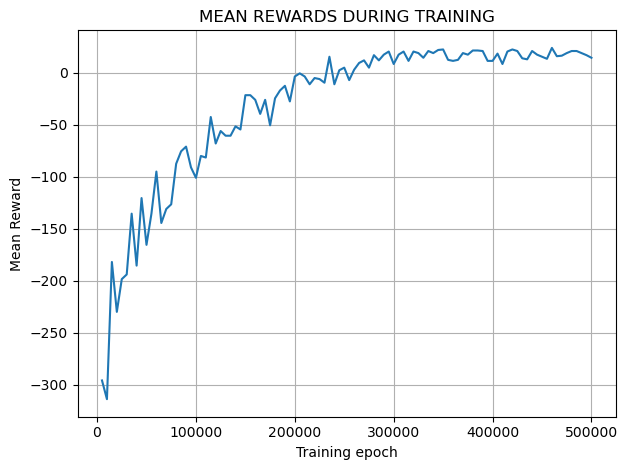

In [17]:
import matplotlib.pyplot as plt

plt.style.use('default')

plt.plot(game_number_list, mean_reward_list)

plt.title("MEAN REWARDS DURING TRAINING")
plt.xlabel("Training epoch")
plt.ylabel("Mean Reward")
#plt.legend()
#plt.savefig('PerformanceVsHsize.png')
plt.tight_layout()
plt.grid(True)
plt.show()


In [18]:
print(game_number_list)
print(mean_reward_list)

[5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000, 105000, 110000, 115000, 120000, 125000, 130000, 135000, 140000, 145000, 150000, 155000, 160000, 165000, 170000, 175000, 180000, 185000, 190000, 195000, 200000, 205000, 210000, 215000, 220000, 225000, 230000, 235000, 240000, 245000, 250000, 255000, 260000, 265000, 270000, 275000, 280000, 285000, 290000, 295000, 300000, 305000, 310000, 315000, 320000, 325000, 330000, 335000, 340000, 345000, 350000, 355000, 360000, 365000, 370000, 375000, 380000, 385000, 390000, 395000, 400000, 405000, 410000, 415000, 420000, 425000, 430000, 435000, 440000, 445000, 450000, 455000, 460000, 465000, 470000, 475000, 480000, 485000, 490000, 495000, 499999]
[-296.0, -314.0, -182.0, -230.0, -198.5, -194.0, -135.5, -185.5, -120.5, -165.5, -135.5, -95.0, -144.5, -131.0, -126.5, -87.5, -75.5, -71.0, -91.0, -101.0, -80.0, -81.5, -42.5, -68.0, -56.0, -60.5, -60.5, -51.5, -54.5, 

# Define different players

In [19]:
def random_agent(gameboard):
    #column = random.choice(range(Xdim))
    column = random.randint(0,Xdim-1)
    while gameboard[column,-1]:
       column = random.randint(0,Xdim-1)
    return(column)

In [20]:
def random_agent_with_winblocklosssearch_middlestart(gameboard):    
        
    # On the first move, start in the middle
    if (-1) not in gameboard: 
        return(int(Xdim/2))  
    
    # Take a win if you have it
    possible_win,win_column=check_for_possible_win(gameboard)
    if possible_win:
        return(win_column)
    
    # Make a block if you need it
    possible_block,block_column=check_for_possible_win(-1*gameboard)
    if possible_block: # Make a block if you need it
        return(block_column)
    
    Qstate_value = [0.0 for i in range(Xdim)]
    for column in range(Xdim):
        if gameboard[column,-1]:
            Qstate_value[column]= -MAX # don't allow an illegal move into a full column
        else:
            Qstate_value[column] = random.random() # Default is random
            # Check to see if we have created a winning opportunity for the opponent
            row = list(gameboard[column]).index(0) # Find the lowest open slot in the chosen column
            if (row<Ydim-1):                        # Have we created a new legal move?
                gameboard_possible = gameboard.copy()
                gameboard_possible[column,row] = 1
                gameboard_possible[column,row+1] = -1
                created_loss = check_for_win(-1*gameboard_possible, column, row+1) # Is the opponent's new move a winning move?
                if (created_loss):
                    Qstate_value[column] = -MAX/2 # Avoid giving them an opportunity
                        
    column = Qstate_value.index(max(Qstate_value))
    return(column)


In [21]:
#
# Trained agent
#
tf.reset_default_graph()
#mainQN = Qnetwork(h_size, action_space_size, learning_rate, "main")
#targetQN = Qnetwork(h_size, action_space_size, learning_rate, "target")
mainQN = Qnetwork(h_size, 1, learning_rate, "main")
targetQN = Qnetwork(h_size, 1, learning_rate, "target")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

#trainables = tf.trainable_variables()
#update_target_ops = update_target_graph("main", "target")
#myBuffer = experience_buffer()

def trained_agent(gameboard):
    Qstate_value = [0.0 for i in range(Xdim)]
    for column in range(Xdim):
        if gameboard[column,-1]:
            Qstate_value[column]= -MAX # don't allow an illegal move into a full column
        else:
            row = list(gameboard[column]).index(0) # Find the lowest open slot in the chosen column #new
            gameboard_possible = gameboard.copy()
            gameboard_possible[column,row] = 1
  
            observations = np.reshape(gameboard_possible, [gameboard_possible.shape[0], gameboard_possible.shape[1], 1]) #new
            observation = np.concatenate([observations, observations, observations], axis=2)
            Qvalue = sess.run(mainQN.q_out,feed_dict={mainQN.observation_input:[observation]})[0] #new
            Qstate_value[column]=Qvalue[0]
    
    count = Qstate_value.count(max(Qstate_value))
    if count>1:
        column = random.randint(0,Xdim-1)
        while Qstate_value[column] != max(Qstate_value):
            column=random.randint(0,Xdim-1)
        #print(count,'values tied for the max')
    else:
        column = Qstate_value.index(max(Qstate_value)) # Find the first/only occurence of the max value
    return(column)
        

In [22]:
def trained_agent_with_winsearch(gameboard):
       
    # MIDDLESTART: On the first move, start in the middle
    #if (-1) not in gameboard: 
        #return(int(Xdim/2))  
    
    # WINSEARCH: Take a win if you have it
    possible_win,win_column=check_for_possible_win(gameboard)
    if possible_win:
        return(win_column)
    
    # BLOCKSEARCH: Make a block if you need it
    #possible_block,block_column=check_for_possible_win(-1*gameboard)
    #if possible_block: # Make a block if you need it
        #return(block_column)
       
    # Find the best Qvalue among all the options
    Qstate_value = [0.0 for i in range(Xdim)]
    for column in range(Xdim):
        if gameboard[column,-1]:
            Qstate_value[column]= -MAX # don't allow an illegal move into a full column
        else:
            row = list(gameboard[column]).index(0) # Find the lowest open slot in the chosen column #new
            gameboard_possible = gameboard.copy()
            gameboard_possible[column,row] = 1
            #possible_loss, loss_column = check_for_possible_win(-1*gameboard_possible) # LOSSSEARCH
            #if (possible_loss): # avoid giving them an opportunity                     # LOSSSEARCH
                #Qstate_value[column] = -MAX/2                                          # LOSSSEARCH
            #else:                                                                      # LOSSSEARCH
            observations = np.reshape(gameboard_possible, [gameboard_possible.shape[0], gameboard_possible.shape[1], 1]) #new
            observation = np.concatenate([observations, observations, observations], axis=2)
            Qvalue = sess.run(mainQN.q_out,feed_dict={mainQN.observation_input:[observation]})[0] #new
            Qstate_value[column]=Qvalue[0]
    
    count = Qstate_value.count(max(Qstate_value))
    if count>1:
        column = random.randint(0,Xdim-1)
        while Qstate_value[column] != max(Qstate_value):
            column=random.randint(0,Xdim-1)
        #print(count,'values tied for the max')
    else:
        column = Qstate_value.index(max(Qstate_value)) # Find the first/only occurence of the max value
    #column = Xdim -1 - Qstate_value[::-1].index(max(Qstate_value))  # Find the last occurance of the max value # deleteme?
    return(column)

In [23]:
def trained_agent_with_winlosssearch_middlestart(gameboard):
       
    # MIDDLESTART: On the first move, start in the middle
    if (-1) not in gameboard: 
        return(int(Xdim/2))  
    
    # WINSEARCH: Take a win if you have it
    possible_win,win_column=check_for_possible_win(gameboard)
    if possible_win:
        return(win_column)
    
    # BLOCKSEARCH: Make a block if you need it
    possible_block,block_column=check_for_possible_win(-1*gameboard)
    if possible_block: # Make a block if you need it
        return(block_column)
       
    # Find the best Qvalue among all the options
    Qstate_value = [0.0 for i in range(Xdim)]
    for column in range(Xdim):
        if gameboard[column,-1]:
            Qstate_value[column]= -MAX # don't allow an illegal move into a full column
        else:
            row = list(gameboard[column]).index(0) # Find the lowest open slot in the chosen column #new
            gameboard_possible = gameboard.copy()
            gameboard_possible[column,row] = 1
            possible_loss, loss_column = check_for_possible_win(-1*gameboard_possible) # LOSSSEARCH
            if (possible_loss): # avoid giving them an opportunity                     # LOSSSEARCH
                Qstate_value[column] = -MAX/2                                          # LOSSSEARCH
            else:                                                                      # LOSSSEARCH
                observations = np.reshape(gameboard_possible, [gameboard_possible.shape[0], gameboard_possible.shape[1], 1]) #new
                observation = np.concatenate([observations, observations, observations], axis=2)
                Qvalue = sess.run(mainQN.q_out,feed_dict={mainQN.observation_input:[observation]})[0] #new
                Qstate_value[column]=Qvalue[0]
    
    count = Qstate_value.count(max(Qstate_value))
    if count>1:
        column = random.randint(0,Xdim-1)
        while Qstate_value[column] != max(Qstate_value):
            column=random.randint(0,Xdim-1)
        #print(count,'values tied for the max')
    else:
        column = Qstate_value.index(max(Qstate_value)) # Find the first/only occurence of the max value
    #column = Xdim -1 - Qstate_value[::-1].index(max(Qstate_value))  # Find the last occurance of the max value # deleteme?
    return(column)

In [24]:
def trained_agent_with_middlestart(gameboard):
           
    # MIDDLESTART: On the first move, start in the middle
    if (-1) not in gameboard: 
        return(int(Xdim/2))  
    
     # WINSEARCH: Take a win if you have it
    #possible_win,win_column=check_for_possible_win(gameboard)
    #if possible_win:
        #return(win_column)
    
    # BLOCKSEARCH: Make a block if you need it
    #possible_block,block_column=check_for_possible_win(-1*gameboard)
    #if possible_block: # Make a block if you need it
        #return(block_column)
       
    # Find the best Qvalue among all the options
    Qstate_value = [0.0 for i in range(Xdim)]
    for column in range(Xdim):
        if gameboard[column,-1]:
            Qstate_value[column]= -MAX # don't allow an illegal move into a full column
        else:
            row = list(gameboard[column]).index(0) # Find the lowest open slot in the chosen column #new
            gameboard_possible = gameboard.copy()
            gameboard_possible[column,row] = 1
            #possible_loss, loss_column = check_for_possible_win(-1*gameboard_possible) # LOSSSEARCH
            #if (possible_loss): # avoid giving them an opportunity                     # LOSSSEARCH
                #Qstate_value[column] = -MAX/2                                          # LOSSSEARCH
            #else:                                                                      # LOSSSEARCH
            observations = np.reshape(gameboard_possible, [gameboard_possible.shape[0], gameboard_possible.shape[1], 1]) #new
            observation = np.concatenate([observations, observations, observations], axis=2)
            Qvalue = sess.run(mainQN.q_out,feed_dict={mainQN.observation_input:[observation]})[0] #new
            Qstate_value[column]=Qvalue[0]
    
    count = Qstate_value.count(max(Qstate_value))
    if count>1:
        column = random.randint(0,Xdim-1)
        while Qstate_value[column] != max(Qstate_value):
            column=random.randint(0,Xdim-1)
        #print(count,'values tied for the max')
    else:
        column = Qstate_value.index(max(Qstate_value)) # Find the first/only occurence of the max value
    #column = Xdim -1 - Qstate_value[::-1].index(max(Qstate_value))  # Find the last occurance of the max value # deleteme?
    return(column)

In [25]:
def random_agent_with_winlosssearch(gameboard):
    
    # Take a win if you have it
    possible_win,win_column=check_for_possible_win(gameboard)
    if possible_win:
        return(win_column)
    
    # Make a block if you need it
    possible_block,block_column=check_for_possible_win(-1*gameboard)
    if possible_block: # Make a block if you need it
        return(block_column)
    
    Qstate_value = [0.0 for i in range(Xdim)]
    for column in range(Xdim):
        if gameboard[column,-1]:
            Qstate_value[column]= -MAX # don't allow an illegal move into a full column
        else:
            row = list(gameboard[column]).index(0) # Find the lowest open slot in the chosen column #new
            gameboard_possible = gameboard.copy()
            gameboard_possible[column,row] = 1
            possible_loss, loss_column = check_for_possible_win(-1*gameboard_possible)
            if (possible_loss): # avoid giving them an opportunity
                Qstate_value[column] = -MAX/2
            else:
                # Default is random
                Qstate_value[column]=random.random()
                        
    column = Qstate_value.index(max(Qstate_value))
    return(column)


In [26]:
def random_agent_with_winlosssearch_middlestart(gameboard):    
        
    # On the first move, start in the middle
    if (-1) not in gameboard: 
        return(int(Xdim/2))  
    
    # Take a win if you have it
    possible_win,win_column=check_for_possible_win(gameboard)
    if possible_win:
        return(win_column)
    
    # Make a block if you need it
    possible_block,block_column=check_for_possible_win(-1*gameboard)
    if possible_block: # Make a block if you need it
        return(block_column)
    
    Qstate_value = [0.0 for i in range(Xdim)]
    for column in range(Xdim):
        if gameboard[column,-1]:
            Qstate_value[column]= -MAX # don't allow an illegal move into a full column
        else:
            row = list(gameboard[column]).index(0) # Find the lowest open slot in the chosen column #new
            gameboard_possible = gameboard.copy()
            gameboard_possible[column,row] = 1
            possible_loss, loss_column = check_for_possible_win(-1*gameboard_possible)
            if (possible_loss): # avoid giving them an opportunity
                Qstate_value[column] = -MAX/2
            else:
                # Default is random
                Qstate_value[column]=random.random()
                        
    column = Qstate_value.index(max(Qstate_value))
    return(column)


In [27]:
# Call this routine every move to evaluate what the player accomplished or missed
#
def update_stats(gameboard,column,row,episode_steps,victories,possible_wins,missed_wins,possible_blocks,missed_blocks, \
                 created_possible_losses, middle_starts):
    global player1_victories
    global player2_victories
    done=0
    
    #Did we start in the middle?
    if (episode_steps==1) and (column==int(Xdim/2)):
        middle_starts+=1                 
    
    # Did we win?
    if check_for_win(gameboard,column,row):
        victories+=1
        possible_wins+=1
        if (episode_steps % 2):
            player1_victories+=1
        else:
            player2_victories+=1
        done=1
        return(done,victories,possible_wins,missed_wins,possible_blocks,missed_blocks,created_possible_losses,middle_starts)
        
    # Did we miss a possible win?
    gameboard_before_move = gameboard.copy()
    gameboard_before_move[column,row]=0
    possible_win,win_column=check_for_possible_win(gameboard_before_move)
    if possible_win:
        possible_wins+=1
        missed_wins+=1
        
    # Are we making a block?
    gameboard_opponent = -1*gameboard
    gameboard_opponent[column,row]=1
    if check_for_win(gameboard_opponent,column,row): # see if we are making a block
        possible_blocks+=1
        return(done,victories,possible_wins,missed_wins,possible_blocks,missed_blocks,created_possible_losses,middle_starts)
        
    #Is there a non-losing move?
    non_losing_move = [1 for i in range(Xdim)]
    for possible_column in range(Xdim):
        if gameboard_before_move[possible_column,-1]: # Rule out this column if it's full
            non_losing_move[possible_column]=0
            continue
        possible_row = list(gameboard_before_move[possible_column]).index(0) # Find the lowest open slot in the chosen column 
        gameboard_possible = gameboard_before_move.copy()
        gameboard_possible[possible_column,possible_row] = 1
        possible_loss, loss_column = check_for_possible_win(-1*gameboard_possible)
        if possible_loss:
            non_losing_move[possible_column]=0 # Rule out this column if it leads to a possible loss
    if 1 not in non_losing_move:
        return(done,victories,possible_wins,missed_wins,possible_blocks,missed_blocks,created_possible_losses,middle_starts)
              
    #Did we miss a possible block?
    gameboard_opponent = -1*gameboard
    possible_loss,loss_column=check_for_possible_win(gameboard_opponent) # see if the opponent can win next
    gameboard_opponent[column,row]= 0
    possible_block,block_column=check_for_possible_win(gameboard_opponent) # see if there was a block to be made
    if (possible_block):  
        possible_blocks+=1
        missed_blocks+=1
    else:
        if (possible_loss): # we have created an opportunity for our opponent
            created_possible_losses+=1
            
    done=0
    return(done,victories,possible_wins,missed_wins,possible_blocks,missed_blocks,created_possible_losses,middle_starts)

In [28]:
# Call this routine every move to assist debugging
#
def update_stats_verbose(gameboard,column,row,episode_steps,victories,possible_wins,missed_wins,possible_blocks,missed_blocks, \
                 created_possible_losses, middle_starts):
    global player1_victories
    global player2_victories
    done=0
    
    #Did we start in the middle?
    if (episode_steps==1) and (column==int(Xdim/2)):
        middle_starts+=1                 
    
    # Did we win?
    if check_for_win(gameboard,column,row):
        victories+=1
        possible_wins+=1
        if (episode_steps % 2):
            player1_victories+=1
        else:
            player2_victories+=1
        done=1
        return(done,victories,possible_wins,missed_wins,possible_blocks,missed_blocks,created_possible_losses,middle_starts)
        
    # Did we miss a possible win?
    gameboard_before_move = gameboard.copy()
    gameboard_before_move[column,row]=0
    possible_win,win_column=check_for_possible_win(gameboard_before_move)
    if possible_win:
        possible_wins+=1
        missed_wins+=1
        print('MISSED WIN')
        print('\nBefore move')
        display_gameboard(gameboard_before_move)
        display_gameboard(gameboard)
        print('column =',column)
        
    # Are we making a block?
    gameboard_opponent = -1*gameboard
    gameboard_opponent[column,row]=1
    if check_for_win(gameboard_opponent,column,row): # see if we are making a block
        possible_blocks+=1
        return(done,victories,possible_wins,missed_wins,possible_blocks,missed_blocks,created_possible_losses,middle_starts)
        
    #Is there a non-losing move?
    non_losing_move = [1 for i in range(Xdim)]
    for possible_column in range(Xdim):
        if gameboard_before_move[possible_column,-1]: # Rule out this column if it's full
            non_losing_move[possible_column]=0
            continue
        possible_row = list(gameboard_before_move[possible_column]).index(0) # Find the lowest open slot in the chosen column 
        gameboard_possible = gameboard_before_move.copy()
        gameboard_possible[possible_column,possible_row] = 1
        possible_loss, loss_column = check_for_possible_win(-1*gameboard_possible)
        if possible_loss:
            non_losing_move[possible_column]=0 # Rule out this column if it leads to a possible loss
    if 1 not in non_losing_move:
        return(done,victories,possible_wins,missed_wins,possible_blocks,missed_blocks,created_possible_losses,middle_starts)
              
    #Did we miss a possible block?
    gameboard_opponent = -1*gameboard
    possible_loss,loss_column=check_for_possible_win(gameboard_opponent) # see if the opponent can win next
    gameboard_opponent[column,row]= 0
    possible_block,block_column=check_for_possible_win(gameboard_opponent) # see if there was a block to be made
    if (possible_block):  
        possible_blocks+=1
        missed_blocks+=1
        print('MISSED BLOCK')
        print('\nBefore move')
        display_gameboard(gameboard_before_move)
        display_gameboard(gameboard)
        print('column =',column)
    else:
        if (possible_loss): # we have created an opportunity for our opponent
            created_possible_losses+=1
            print('CREATED LOSS')
            print('\nBefore move')
            display_gameboard(gameboard_before_move)
            display_gameboard(gameboard)
            print('column =',column)
            
    done=0
    return(done,victories,possible_wins,missed_wins,possible_blocks,missed_blocks,created_possible_losses,middle_starts)

In [29]:
def print_training_parameters():
    print('batch_size=', batch_size)
    print('update_freq = ',update_freq)
    print('targetQ_y=',targetQ_y)
    print('training_games =',training_games)
    print('annealing_time =', annealing_time)
    print('number of units in hidden layer = ',h_size)
    print('learning_rate=' ,learning_rate)
    #print ("Mean Reward: {}".format(np.mean(episode_rewards[-50:])))

# Play two opponents against each other

In [30]:
playerA = trained_agent
playerB = random_agent_with_winblocklosssearch_middlestart
test_games= 10000
test_games= 5000


In [31]:
 print(datetime.datetime.now())

2022-04-21 15:08:02.161588


In [32]:
#This is up-to-date altered
#
# Play a set of matches
#
global player1_victories
global player2_victories
player1_victories = 0
player2_victories = 0
playerA_victories = 0
playerB_victories = 0
playerA_possible_wins = 0
playerB_possible_wins = 0
playerA_missed_wins = 0
playerB_missed_wins = 0
playerA_possible_blocks = 0
playerB_possible_blocks = 0
playerA_missed_blocks = 0
playerB_missed_blocks = 0
playerA_created_possible_losses = 0
playerB_created_possible_losses = 0
playerA_starts = 0
playerB_starts = 0
playerA_middle_starts = 0
playerB_middle_starts = 0
playerA_firstplayerwins = 0
playerB_firstplayerwins = 0
tied_games=0
gameboard_history = np.zeros((test_games,Xdim,Ydim),dtype=int) # use this to use gameboard_history to record all final gameboards
playerA_distribution = [0]*Xdim
playerB_distribution = [0]*Xdim

with tf.Session() as sess:
  sess.run(init)
  ckpt = tf.train.get_checkpoint_state(model_path)
  saver.restore(sess,ckpt.model_checkpoint_path)
  print('Model loaded')
    
  for game in range(test_games):   
    # reset gameboard
    gameboard = np.zeros((Xdim,Ydim),dtype=int) 
    #gameboard_history = np.zeros((Xdim*Ydim,Xdim,Ydim),dtype=int) # Use this to use gameboard_history to record steps in a game
    observations = np.reshape(gameboard, [gameboard.shape[0], gameboard.shape[1], 1]) #new
    observation = np.concatenate([observations, observations, observations], axis=2)
    done = False
       
    playerA_first = (random.random()<0.5)
    if playerA_first:
        playerA_starts+=1
    else:
        playerB_starts+=1
    episode_steps = 0    
    while not done and 0 in gameboard:
        
        #Player A
        if (episode_steps>0) or playerA_first:
            gameboard *=-1 # switch sides every turn 
            episode_steps+=1
            # Determine our move
            column=playerA(gameboard)
            playerA_distribution[column]+=1 # deleteme
            #display_gameboard(gameboard) # deleteme
            #print('trained', column) # deleteme
            row = list(gameboard[column]).index(0) # Find the lowest open slot in the chosen column 
            gameboard[column,row] = 1 
            # Update our stats
            done, playerA_victories, playerA_possible_wins, playerA_missed_wins, \
                playerA_possible_blocks, playerA_missed_blocks, playerA_created_possible_losses, playerA_middle_starts\
                = update_stats(gameboard,column, row,episode_steps, playerA_victories, playerA_possible_wins, playerA_missed_wins, \
                playerA_possible_blocks, playerA_missed_blocks, playerA_created_possible_losses, playerA_middle_starts)
            if done:
                gameboard_history[game] = gameboard
                if playerA_first:
                    playerA_firstplayerwins +=1
                break # PlayerA won!
        
        # Check for a tie
        if (0 not in gameboard):
            tied_games+=1
            gameboard_history[game] = gameboard
            break
            
        #PlayerB        
        gameboard *=-1 # switch sides every turn 
        episode_steps+=1
        # Determine our move
        #display_gameboard(gameboard) # deleteme
        column=playerB(gameboard)
        playerB_distribution[column]+=1 # deleteme
        row = list(gameboard[column]).index(0) # Find the lowest open slot in the chosen column 
        gameboard[column,row] = 1 
        # Update our stats
        done, playerB_victories, playerB_possible_wins, playerB_missed_wins, \
            playerB_possible_blocks, playerB_missed_blocks, playerB_created_possible_losses, playerB_middle_starts\
            = update_stats(gameboard,column, row,episode_steps, playerB_victories, playerB_possible_wins, playerB_missed_wins, \
            playerB_possible_blocks, playerB_missed_blocks, playerB_created_possible_losses, playerB_middle_starts)
        if done:
            gameboard_history[game] = gameboard
            if not playerA_first:
                playerB_firstplayerwins +=1
            #print('playerB wins!')  # deleteme
            break # PlayerB won!
            
        # Check for a tie
        if (0 not in gameboard):
            tied_games+=1
            gameboard_history[game] = gameboard
            break
     
    if (TRAIN_AFTER_TESTGAMES):
        # At the end of each game, Get a random batch of experiences.
        trainBatch = myBuffer.sample(batch_size) 
        # Below we perform the Double-DQN update to the target Q-values
        Q1 = sess.run(mainQN.predict, feed_dict={mainQN.observation_input: np.stack(trainBatch[:,3], axis=0)})
        Q2 = sess.run(targetQN.q_out, feed_dict={targetQN.observation_input: np.stack(trainBatch[:,3], axis=0)})
        end_multiplier = -(trainBatch[:,4] - 1)
        doubleQ = Q2[range(batch_size),Q1]
        targetQ = trainBatch[:,2] + (targetQ_y*doubleQ * end_multiplier)
        # Update the network with our target values.
        _, q_loss = sess.run([mainQN.update, mainQN.loss],
            feed_dict={mainQN.observation_input:np.stack(trainBatch[:,0], axis=0),
                    mainQN.targetQ:targetQ, 
                    mainQN.actions:trainBatch[:,1]})
        losses.append(q_loss)

print('\nPlayerA is a',playerA)
print('PlayerB is a',playerB)
print(f'\nPlayerA won {playerA_victories} games for {100*playerA_victories/test_games}%')
print(f'PlayerA went first {100*playerA_starts/test_games}% of the time and won {playerA_firstplayerwins} of those games for {round(10*100*playerA_firstplayerwins/max(1,playerA_starts))/10}%')
print(f'PlayerA started in the middle {playerA_middle_starts} times out of {playerA_starts} ({round(10*100*playerA_middle_starts/max(1,playerA_starts))/10}%)')
print(f'PlayerA won {playerA_victories} times out of {playerA_possible_wins} chances ({round(10*100*playerA_victories/max(1,playerA_possible_wins))/10}%)')
print(f'PlayerA blocked {playerA_possible_blocks-playerA_missed_blocks} times out of {playerA_possible_blocks} chances ({round(10*100*(1-playerA_missed_blocks/max(1,playerA_possible_blocks)))/10}%)')
print(f'PlayerA created {playerA_created_possible_losses} opportunities for PlayerB')
print(f'PlayerA distribution = {playerA_distribution}')
print(f'\nPlayerB won {playerB_victories} games for {100*playerB_victories/test_games}%')
print(f'PlayerB went first {100*playerB_starts/test_games}% of the time and won {playerB_firstplayerwins} of those games for {round(10*100*playerB_firstplayerwins/max(1,playerB_starts))/10}%')
print(f'PlayerB started in the middle {playerB_middle_starts} times out of {playerB_starts} ({round(10*100*playerB_middle_starts/max(1,playerB_starts))/10}%)')
print(f'PlayerB won {playerB_victories} times out of {playerB_possible_wins} chances ({round(10*100*playerB_victories/max(1,playerB_possible_wins))/10}%)')
print(f'PlayerB blocked {playerB_possible_blocks-playerB_missed_blocks} times out of {playerB_possible_blocks} chances ({round(10*100*(1-playerB_missed_blocks/max(1,playerB_possible_blocks)))/10}%)')
print(f'PlayerB created {playerB_created_possible_losses} opportunities for PlayerA')
print(f'PlayerB distribution = {playerB_distribution}')
print(f'\nPlayer1 won {player1_victories} games for {100*player1_victories/test_games}%')
print(f'Player2 won {player2_victories} games for {100*player2_victories/test_games}%')
print(f'{tied_games} tied games for {100*tied_games/test_games}%')

INFO:tensorflow:Restoring parameters from ./Trainings_500Ktraining/models4/dqn_training_reducedLossPenalty\model-499999.cptk
Model loaded

PlayerA is a <function trained_agent at 0x000001BF7271EEA0>
PlayerB is a <function random_agent_with_winblocklosssearch_middlestart at 0x000001BF722A6A60>

PlayerA won 4392 games for 87.84%
PlayerA went first 50.3% of the time and won 2349 of those games for 93.4%
PlayerA started in the middle 2515 times out of 2515 (100.0%)
PlayerA won 4392 times out of 4408 chances (99.6%)
PlayerA blocked 4261 times out of 4374 chances (97.4%)
PlayerA created 29 opportunities for PlayerB
PlayerA distribution = [3854, 7685, 9833, 12772, 9309, 6921, 3532]

PlayerB won 446 games for 8.92%
PlayerB went first 49.7% of the time and won 330 of those games for 13.3%
PlayerB started in the middle 2485 times out of 2485 (100.0%)
PlayerB won 446 times out of 446 chances (100.0%)
PlayerB blocked 13299 times out of 13299 chances (100.0%)
PlayerB created 0 opportunities for Pla

In [33]:
print('batch_size=', batch_size)
print('update_freq = ',update_freq)
print('targetQ_y=',targetQ_y)
print('training_games =',training_games)
print('annealing_time =', annealing_time)
print('number of units in hidden layer = ',h_size)
print('learning_rate= ',learning_rate)
print ("Mean Reward: {}".format(np.mean(episode_rewards[-50:])))

batch_size= 64
update_freq =  8
targetQ_y= 0.4
training_games = 1
annealing_time = 0.6
number of units in hidden layer =  512
learning_rate=  0.0003
Mean Reward: 25.0


In [34]:
print(datetime.datetime.now())

2022-04-21 15:15:38.101050


In [35]:
import winsound
frequency = 500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [36]:
def get_Qvalue(gameboard):
    observations = np.reshape(gameboard, [gameboard.shape[0], gameboard.shape[1], 1])
    observation = np.concatenate([observations, observations, observations], axis=2)
    Qvalue = sess.run(mainQN.q_out,feed_dict={mainQN.observation_input:[observation]})[0]
    return(Qvalue[0])


In [37]:
def trained_agent_minimax_lookahead1_pruned(gameboard): # No lookahead discount factor
    
    thresholdA = MAX
    Qstate_valueA = [0.0 for i in range(Xdim)]
    for columnA in range(Xdim):
        gameboardA = gameboard.copy()
        if gameboardA[columnA,-1]:
            Qstate_valueA[columnA]= -MAX # don't allow an illegal move into a full column
        else:
            row = list(gameboardA[columnA]).index(0) # Find the lowest open slot in the chosen column
            gameboardA[columnA,row] = 1
            if (check_for_win(gameboardA,columnA,row)) or (0 not in gameboardA):
                Qstate_valueA[columnA] = get_Qvalue(gameboardA)
                #if (check_for_win(gameboardA,columnA,row)):
                    #Qstate_valueA[columnA] = MAX/2
                #break # No need to evaluate deeper if this terminates the game
            else:
                
                Qstate_valueB = [0.0 for i in range(Xdim)]
                for columnB in range(Xdim):
                    gameboardB = -1*gameboardA.copy()
                    if gameboardB[columnB,-1]:
                        Qstate_valueB[columnB] = -MAX # don't allow an illegal move into a full column
                    else:
                        row = list(gameboardB[columnB]).index(0) # Find the lowest open slot in the chosen column
                        gameboardB[columnB,row] = 1                   
                        #Qstate_valueB[columnB]= get_Qvalue(gameboardB)
                        if (check_for_win(gameboardB,columnB,row)):
                            Qstate_valueB[columnB] = get_Qvalue(gameboardB)
                            #Qstate_valueB[columnB] = MAX/3
                        else:
                            Qstate_valueB[columnB] = get_Qvalue(gameboardB)
                    if (Qstate_valueB[columnB] > thresholdA): # If even one of B's options is higher, we don't need to evaluate further
                        break #PRUNING                           
                
                # This runs at the end of the columnB loop
                #columnBmax = Qstate_valueB.index(max(Qstate_valueB)) #opponent maximizes their Qvalue for each option
                Qstate_valueB_max = max(Qstate_valueB)
                if (Qstate_valueB_max<thresholdA):
                    thresholdA = Qstate_valueB_max
                Qstate_valueA[columnA] = -1*Qstate_valueB_max # Invert the opponent's gain to be our loss
   
    count = Qstate_valueA.count(max(Qstate_valueA))
    if count>1:
        columnA = random.randint(0,Xdim-1)
        while Qstate_valueA[columnA] != max(Qstate_valueA):
            columnA=random.randint(0,Xdim-1)
    else:
        columnA = Qstate_valueA.index(max(Qstate_valueA)) # Find the first/only occurence of the max value
    
    return(columnA)


In [38]:
def trained_agent_minimax_lookahead1_discounted(gameboard, discount):
    
    thresholdA = MAX
    Qstate_valueA = [0.0 for i in range(Xdim)]
    for columnA in range(Xdim):
        gameboardA = gameboard.copy()
        if gameboardA[columnA,-1]:
            Qstate_valueA[columnA]= -MAX # don't allow an illegal move into a full column
        else:
            row = list(gameboardA[columnA]).index(0) # Find the lowest open slot in the chosen column
            gameboardA[columnA,row] = 1
            if (check_for_win(gameboardA,columnA,row)) or (0 not in gameboardA):
                Qstate_valueA[columnA] = get_Qvalue(gameboardA)
                #if (check_for_win(gameboardA,columnA,row)): 
                    #Qstate_valueA[columnA] = MAX/2  # Use if we want to explicitly identify wins
                ## No need to evaluate deeper if this terminates the game
            else:
                
                Qstate_valueB = [0.0 for i in range(Xdim)]
                for columnB in range(Xdim):
                    gameboardB = -1*gameboardA.copy()
                    if gameboardB[columnB,-1]:
                        Qstate_valueB[columnB] = -MAX # don't allow an illegal move into a full column
                    else:
                        row = list(gameboardB[columnB]).index(0) # Find the lowest open slot in the chosen column
                        gameboardB[columnB,row] = 1                   
                        if (check_for_win(gameboardB,columnB,row)):
                            Qstate_valueB[columnB] = get_Qvalue(gameboardB)
                            #Qstate_valueB[columnB] = MAX/3   # Use if we want to explicitly identify wins
                        else:
                            Qstate_valueB[columnB] = get_Qvalue(gameboardB)
                    if (Qstate_valueB[columnB] > thresholdA): # If even one of B's options is higher, we don't need to evaluate further
                        break #PRUNING                           
                
                # This runs at the end of the columnB loop
                #columnBmax = Qstate_valueB.index(max(Qstate_valueB)) #opponent maximizes their Qvalue for each option
                Qstate_valueB_max = max(Qstate_valueB)
                if (Qstate_valueB_max<thresholdA):
                    thresholdA = Qstate_valueB_max
                Qstate_valueA[columnA] = -1*discount*Qstate_valueB_max # Invert the opponent's gain to be our loss
   
    count = Qstate_valueA.count(max(Qstate_valueA))
    if count>1:
        columnA = random.randint(0,Xdim-1)
        while Qstate_valueA[columnA] != max(Qstate_valueA):
            columnA=random.randint(0,Xdim-1)
    else:
        columnA = Qstate_valueA.index(max(Qstate_valueA)) # Find the first/only occurence of the max value
    
    return(columnA)


In [39]:
def trained_agent_minimax_lookahead2_pruned(gameboard):

    thresholdA = MAX
    Qstate_valueA = [0.0 for i in range(Xdim)]
    for columnA in range(Xdim):
        gameboardA = gameboard.copy()
        if gameboardA[columnA,-1]:
            Qstate_valueA[columnA]= -MAX # don't allow an illegal move into a full column
        else:
            row = list(gameboardA[columnA]).index(0) # Find the lowest open slot in the chosen column
            gameboardA[columnA,row] = 1 
            if (check_for_win(gameboardA,columnA,row)) or (0 not in gameboardA):
                Qstate_valueA[columnA] = get_Qvalue(gameboardA)
                #if (check_for_win(gameboardA,columnA,row)):
                    #Qstate_valueA[columnA] = MAX/2
                #break # No need to evaluate deeper if this terminates the game
            else:
                 
                thresholdB = MAX
                Qstate_valueB = [0.0 for i in range(Xdim)]
                for columnB in range(Xdim):
                    gameboardB = -1*gameboardA.copy()
                    if gameboardB[columnB,-1]:
                        Qstate_valueB[columnB] = -MAX # don't allow an illegal move into a full column
                    else:
                        row = list(gameboardB[columnB]).index(0) # Find the lowest open slot in the chosen column
                        gameboardB[columnB,row] = 1                        
                        if (check_for_win(gameboardB,columnB,row)) or (0 not in gameboardB):
                            Qstate_valueB[columnB] = get_Qvalue(gameboardB)
                            #if (check_for_win(gameboardB,columnB,row)):
                                #Qstate_valueB[columnB] = MAX/3
                            #break # No need to evaluate deeper if this terminates the game
                        else:
                        
                            Qstate_valueC = [0.0 for i in range(Xdim)]
                            for columnC in range(Xdim):
                                gameboardC = -1*gameboardB.copy()
                                if gameboardC[columnC,-1]:
                                    Qstate_valueC[columnC] = -MAX # don't allow an illegal move into a full column
                                else:
                                    row = list(gameboardC[columnC]).index(0) # Find the lowest open slot in the chosen column
                                    gameboardC[columnC,row] = 1
                                    if (check_for_win(gameboardC,columnC,row)):
                                        Qstate_valueC[columnC] = get_Qvalue(gameboardC)
                                        #Qstate_valueC[columnC] = MAX/4
                                    else:
                                        Qstate_valueC[columnC]= get_Qvalue(gameboardC)
                                # End of loop of each value of columnC 
                                if (Qstate_valueC[columnC] > thresholdB): # If even one of B's options is higher, we don't need to evaluate further
                                    break #PRUNING
                            # This runs at the end of the columnC loop        
                            #columnCmax = Qstate_valueB.index(max(Qstate_valueC))
                            Qstate_valueC_max = max(Qstate_valueC)
                            if (Qstate_valueC_max<thresholdB):
                                thresholdB = Qstate_valueC_max
                            Qstate_valueB[columnB] = -1*Qstate_valueC_max # Invert the opponent's gain to be our loss
                    
                    # End of loop of each value of columnB
                    if (Qstate_valueB[columnB] > thresholdA): # If even one of B's options is higher, we don't need to evaluate further
                        break #PRUNING       
                
                # This runs at the end of the columnB loop of all values of columnB
                #columnBmax = Qstate_valueB.index(max(Qstate_valueB)) #opponent maximizes their Qvalue for each option
                Qstate_valueB_max = max(Qstate_valueB)
                if (Qstate_valueB_max<thresholdA):
                    thresholdA = Qstate_valueB_max
                Qstate_valueA[columnA] = -1*Qstate_valueB_max # Invert the opponent's gain to be our loss

    count = Qstate_valueA.count(max(Qstate_valueA))
    if count>1:
        columnA = random.randint(0,Xdim-1)
        while Qstate_valueA[columnA] != max(Qstate_valueA):
            columnA=random.randint(0,Xdim-1)
    else:
        columnA = Qstate_valueA.index(max(Qstate_valueA)) # Find the first/only occurence of the max value
    
    return(columnA)


In [40]:
def trained_agent_minimax_lookahead3_pruned(gameboard):

    thresholdA = MAX
    Qstate_valueA = [0.0 for i in range(Xdim)]
    for columnA in range(Xdim):
        gameboardA = gameboard.copy()
        if gameboardA[columnA,-1]:
            Qstate_valueA[columnA]= -MAX # don't allow an illegal move into a full column
        else:
            row = list(gameboardA[columnA]).index(0) # Find the lowest open slot in the chosen column
            gameboardA[columnA,row] = 1 
            if (check_for_win(gameboardA,columnA,row)) or (0 not in gameboardA):
                Qstate_valueA[columnA] = get_Qvalue(gameboardA)
                #if (check_for_win(gameboardA,columnA,row)):
                    #Qstate_valueA[columnA] = MAX/2
                ## No need to evaluate deeper if this terminates the game
            else:
                 
                thresholdB = MAX
                Qstate_valueB = [0.0 for i in range(Xdim)]
                for columnB in range(Xdim):
                    gameboardB = -1*gameboardA.copy()
                    if gameboardB[columnB,-1]:
                        Qstate_valueB[columnB] = -MAX # don't allow an illegal move into a full column
                    else:
                        row = list(gameboardB[columnB]).index(0) # Find the lowest open slot in the chosen column
                        gameboardB[columnB,row] = 1                        
                        if (check_for_win(gameboardB,columnB,row)) or (0 not in gameboardB):
                            Qstate_valueB[columnB] = get_Qvalue(gameboardB)
                            #if (check_for_win(gameboardB,columnB,row)):
                                #Qstate_valueB[columnB] = MAX/3
                            ## No need to evaluate deeper if this terminates the game
                        else:
                        
                            thresholdC = MAX
                            Qstate_valueC = [0.0 for i in range(Xdim)]
                            for columnC in range(Xdim):
                                gameboardC = -1*gameboardB.copy()
                                if gameboardC[columnC,-1]:
                                    Qstate_valueC[columnC] = -MAX # don't allow an illegal move into a full column
                                else:
                                    row = list(gameboardC[columnC]).index(0) # Find the lowest open slot in the chosen column
                                    gameboardC[columnC,row] = 1
                                    if (check_for_win(gameboardC,columnC,row) or (0 not in gameboard)):
                                        Qstate_valueC[columnC] = get_Qvalue(gameboardC)
                                        #if (check_for_win(gameboardB,columnB,row)):
                                            #Qstate_valueB[columnB] = MAX/4
                                        ## No need to evaluate deeper if this terminates the game
                                    else:   
                                        
                                        thresholdD = MAX
                                        Qstate_valueD = [0.0 for i in range(Xdim)]
                                        for columnD in range(Xdim):
                                            gameboardD = -1*gameboardC.copy()
                                            if gameboardD[columnD,-1]:
                                                Qstate_valueD[columnD] = -MAX # don't allow an illegal move into a full column
                                            else:
                                                row = list(gameboardD[columnD]).index(0) # Find the lowest open slot in the chosen column
                                                gameboardC[columnD,row] = 1
                                                if (check_for_win(gameboardD,columnD,row) or 0 not in gameboard):
                                                    Qstate_valueD[columnD] = get_Qvalue(gameboardD)
                                                    #Qstate_valueC[columnD] = MAX/5
                                                else:
                                                    Qstate_valueD[columnD]= get_Qvalue(gameboardD)

                                           # End of loop of each value of columnD 
                                            if (Qstate_valueD[columnD] > thresholdC): # If even one of D's options is higher, we don't need to evaluate further
                                                break #PRUNING
                                        # This runs at the end of the columnC loop        
                                        #columnCmax = Qstate_valueB.index(max(Qstate_valueC))
                                        Qstate_valueD_max = max(Qstate_valueD)
                                        if (Qstate_valueD_max<thresholdC):
                                            thresholdC = Qstate_valueD_max
                                        Qstate_valueC[columnC] = -1*Qstate_valueD_max # Invert the opponent's gain to be our loss                                        
                                        
                                # End of loop of each value of columnC 
                                if (Qstate_valueC[columnC] > thresholdB): # If even one of C's options is higher, we don't need to evaluate further
                                    break #PRUNING
                            # This runs at the end of the columnC loop        
                            #columnCmax = Qstate_valueB.index(max(Qstate_valueC))
                            Qstate_valueC_max = max(Qstate_valueC)
                            if (Qstate_valueC_max<thresholdB):
                                thresholdB = Qstate_valueC_max
                            Qstate_valueB[columnB] = -1*Qstate_valueC_max # Invert the opponent's gain to be our loss
                    
                    # End of loop of each value of columnB
                    if (Qstate_valueB[columnB] > thresholdA): # If even one of B's options is higher, we don't need to evaluate further
                        break #PRUNING                     
                # This runs at the end of the columnB loop of all values of columnB
                #columnBmax = Qstate_valueB.index(max(Qstate_valueB)) #opponent maximizes their Qvalue for each option
                Qstate_valueB_max = max(Qstate_valueB)
                if (Qstate_valueB_max<thresholdA):
                    thresholdA = Qstate_valueB_max
                Qstate_valueA[columnA] = -1*Qstate_valueB_max # Invert the opponent's gain to be our loss

    count = Qstate_valueA.count(max(Qstate_valueA))
    if count>1:
        columnA = random.randint(0,Xdim-1)
        while Qstate_valueA[columnA] != max(Qstate_valueA):
            columnA=random.randint(0,Xdim-1)
    else:
        columnA = Qstate_valueA.index(max(Qstate_valueA)) # Find the first/only occurence of the max value
    
    return(columnA)


In [41]:
def trained_agent_minimax_lookahead3_discounted(gameboard, lookahead_discount):

    thresholdA = MAX
    Qstate_valueA = [0.0 for i in range(Xdim)]
    for columnA in range(Xdim):
        gameboardA = gameboard.copy()
        if gameboardA[columnA,-1]:
            Qstate_valueA[columnA]= -MAX # don't allow an illegal move into a full column
        else:
            row = list(gameboardA[columnA]).index(0) # Find the lowest open slot in the chosen column
            gameboardA[columnA,row] = 1 
            if (check_for_win(gameboardA,columnA,row)) or (0 not in gameboardA):
                Qstate_valueA[columnA] = get_Qvalue(gameboardA)
                #if (check_for_win(gameboardA,columnA,row)):
                    #Qstate_valueA[columnA] = MAX/2
                ## No need to evaluate deeper if this terminates the game
            else:
                 
                thresholdB = MAX
                Qstate_valueB = [0.0 for i in range(Xdim)]
                for columnB in range(Xdim):
                    gameboardB = -1*gameboardA.copy()
                    if gameboardB[columnB,-1]:
                        Qstate_valueB[columnB] = -MAX # don't allow an illegal move into a full column
                    else:
                        row = list(gameboardB[columnB]).index(0) # Find the lowest open slot in the chosen column
                        gameboardB[columnB,row] = 1                        
                        if (check_for_win(gameboardB,columnB,row)) or (0 not in gameboardB):
                            Qstate_valueB[columnB] = get_Qvalue(gameboardB)
                            #if (check_for_win(gameboardB,columnB,row)):
                                #Qstate_valueB[columnB] = MAX/3
                            ## No need to evaluate deeper if this terminates the game
                        else:
                        
                            thresholdC = MAX
                            Qstate_valueC = [0.0 for i in range(Xdim)]
                            for columnC in range(Xdim):
                                gameboardC = -1*gameboardB.copy()
                                if gameboardC[columnC,-1]:
                                    Qstate_valueC[columnC] = -MAX # don't allow an illegal move into a full column
                                else:
                                    row = list(gameboardC[columnC]).index(0) # Find the lowest open slot in the chosen column
                                    gameboardC[columnC,row] = 1
                                    if (check_for_win(gameboardC,columnC,row) or (0 not in gameboard)):
                                        Qstate_valueC[columnC] = get_Qvalue(gameboardC)
                                        #if (check_for_win(gameboardB,columnB,row)):
                                            #Qstate_valueB[columnB] = MAX/4
                                        ## No need to evaluate deeper if this terminates the game
                                    else:   
                                        
                                        thresholdD = MAX
                                        Qstate_valueD = [0.0 for i in range(Xdim)]
                                        for columnD in range(Xdim):
                                            gameboardD = -1*gameboardC.copy()
                                            if gameboardD[columnD,-1]:
                                                Qstate_valueD[columnD] = -MAX # don't allow an illegal move into a full column
                                            else:
                                                row = list(gameboardD[columnD]).index(0) # Find the lowest open slot in the chosen column
                                                gameboardC[columnD,row] = 1
                                                if (check_for_win(gameboardD,columnD,row) or 0 not in gameboard):
                                                    Qstate_valueD[columnD] = get_Qvalue(gameboardD)
                                                    #Qstate_valueC[columnD] = MAX/5
                                                else:
                                                    Qstate_valueD[columnD]= get_Qvalue(gameboardD)

                                           # End of loop of each value of columnD 
                                            if (Qstate_valueD[columnD] > thresholdC): # If even one of D's options is higher, we don't need to evaluate further
                                                break #PRUNING
                                        # This runs at the end of the columnC loop        
                                        #columnCmax = Qstate_valueB.index(max(Qstate_valueC))
                                        Qstate_valueD_max = max(Qstate_valueD)
                                        if (Qstate_valueD_max<thresholdC):
                                            thresholdC = Qstate_valueD_max
                                        Qstate_valueC[columnC] = -1*lookahead_discount*Qstate_valueD_max # Invert the opponent's gain to be our loss                                        
                                        
                                # End of loop of each value of columnC 
                                if (Qstate_valueC[columnC] > thresholdB): # If even one of C's options is higher, we don't need to evaluate further
                                    break #PRUNING
                            # This runs at the end of the columnC loop        
                            #columnCmax = Qstate_valueB.index(max(Qstate_valueC))
                            Qstate_valueC_max = max(Qstate_valueC)
                            if (Qstate_valueC_max<thresholdB):
                                thresholdB = Qstate_valueC_max
                            Qstate_valueB[columnB] = -1*lookahead_discount*Qstate_valueC_max # Invert the opponent's gain to be our loss
                    
                    # End of loop of each value of columnB
                    if (Qstate_valueB[columnB] > thresholdA): # If even one of B's options is higher, we don't need to evaluate further
                        break #PRUNING                     
                # This runs at the end of the columnB loop of all values of columnB
                #columnBmax = Qstate_valueB.index(max(Qstate_valueB)) #opponent maximizes their Qvalue for each option
                Qstate_valueB_max = max(Qstate_valueB)
                if (Qstate_valueB_max<thresholdA):
                    thresholdA = Qstate_valueB_max
                Qstate_valueA[columnA] = -1*lookahead_discount*Qstate_valueB_max # Invert the opponent's gain to be our loss

    count = Qstate_valueA.count(max(Qstate_valueA))
    if count>1:
        columnA = random.randint(0,Xdim-1)
        while Qstate_valueA[columnA] != max(Qstate_valueA):
            columnA=random.randint(0,Xdim-1)
    else:
        columnA = Qstate_valueA.index(max(Qstate_valueA)) # Find the first/only occurence of the max value
    
    return(columnA)


# PLAY THE MINIMAX AGENT AGAINST THE RANDOM AGENT

In [42]:
playerA = trained_agent_minimax_lookahead1_pruned
playerB = random_agent_with_winblocklosssearch_middlestart
test_games=10000
test_games= 5000


In [43]:
 print(datetime.datetime.now())

2022-04-21 15:15:39.278049


In [44]:
#
# THIS CODE IS DUPLICATED FOR THE PURPOSES OF ILLUSTRATING THE PERFOMANCE OF DIFFERENT AGENTS TO THE REVIEWER
#
#
#This is up-to-date altered
print(datetime.datetime.now())
#
# Play a set of matches
#
global player1_victories
global player2_victories
player1_victories = 0
player2_victories = 0
playerA_victories = 0
playerB_victories = 0
playerA_possible_wins = 0
playerB_possible_wins = 0
playerA_missed_wins = 0
playerB_missed_wins = 0
playerA_possible_blocks = 0
playerB_possible_blocks = 0
playerA_missed_blocks = 0
playerB_missed_blocks = 0
playerA_created_possible_losses = 0
playerB_created_possible_losses = 0
playerA_starts = 0
playerB_starts = 0
playerA_middle_starts = 0
playerB_middle_starts = 0
playerA_firstplayerwins = 0
playerB_firstplayerwins = 0
tied_games=0
gameboard_history = np.zeros((test_games,Xdim,Ydim),dtype=int) # use this to use gameboard_history to record all final gameboards
playerA_distribution = [0]*Xdim
playerB_distribution = [0]*Xdim

with tf.Session() as sess:
  sess.run(init)
  ckpt = tf.train.get_checkpoint_state(model_path)
  saver.restore(sess,ckpt.model_checkpoint_path)
  print('Model loaded')
    
  for game in range(test_games):   
    # reset gameboard
    gameboard = np.zeros((Xdim,Ydim),dtype=int) 
    #gameboard_history = np.zeros((Xdim*Ydim,Xdim,Ydim),dtype=int) # Use this to use gameboard_history to record steps in a game
    observations = np.reshape(gameboard, [gameboard.shape[0], gameboard.shape[1], 1]) #new
    observation = np.concatenate([observations, observations, observations], axis=2)
    done = False
       
    playerA_first = (random.random()<0.5)
    if playerA_first:
        playerA_starts+=1
    else:
        playerB_starts+=1
    episode_steps = 0    
    while not done and 0 in gameboard:
        
        #Player A
        if (episode_steps>0) or playerA_first:
            gameboard *=-1 # switch sides every turn 
            episode_steps+=1
            # Determine our move
            column=playerA(gameboard)
            playerA_distribution[column]+=1 # deleteme
            #display_gameboard(gameboard) # deleteme
            #print('trained', column) # deleteme
            row = list(gameboard[column]).index(0) # Find the lowest open slot in the chosen column 
            gameboard[column,row] = 1 
            # Update our stats
            done, playerA_victories, playerA_possible_wins, playerA_missed_wins, \
                playerA_possible_blocks, playerA_missed_blocks, playerA_created_possible_losses, playerA_middle_starts\
                = update_stats(gameboard,column, row,episode_steps, playerA_victories, playerA_possible_wins, playerA_missed_wins, \
                playerA_possible_blocks, playerA_missed_blocks, playerA_created_possible_losses, playerA_middle_starts)
            if done:
                gameboard_history[game] = gameboard
                if playerA_first:
                    playerA_firstplayerwins +=1
                break # PlayerA won!
        
        # Check for a tie
        if (0 not in gameboard):
            tied_games+=1
            gameboard_history[game] = gameboard
            break
            
        #PlayerB        
        gameboard *=-1 # switch sides every turn 
        episode_steps+=1
        # Determine our move
        #display_gameboard(gameboard) # deleteme
        column=playerB(gameboard)
        playerB_distribution[column]+=1 # deleteme
        row = list(gameboard[column]).index(0) # Find the lowest open slot in the chosen column 
        gameboard[column,row] = 1 
        # Update our stats
        done, playerB_victories, playerB_possible_wins, playerB_missed_wins, \
            playerB_possible_blocks, playerB_missed_blocks, playerB_created_possible_losses, playerB_middle_starts\
            = update_stats(gameboard,column, row,episode_steps, playerB_victories, playerB_possible_wins, playerB_missed_wins, \
            playerB_possible_blocks, playerB_missed_blocks, playerB_created_possible_losses, playerB_middle_starts)
        if done:
            gameboard_history[game] = gameboard
            if not playerA_first:
                playerB_firstplayerwins +=1
            #print('playerB wins!')  # deleteme
            break # PlayerB won!
            
        # Check for a tie
        if (0 not in gameboard):
            tied_games+=1
            gameboard_history[game] = gameboard
            break
     
    if (TRAIN_AFTER_TESTGAMES):
        # At the end of each game, Get a random batch of experiences.
        trainBatch = myBuffer.sample(batch_size) 
        # Below we perform the Double-DQN update to the target Q-values
        Q1 = sess.run(mainQN.predict, feed_dict={mainQN.observation_input: np.stack(trainBatch[:,3], axis=0)})
        Q2 = sess.run(targetQN.q_out, feed_dict={targetQN.observation_input: np.stack(trainBatch[:,3], axis=0)})
        end_multiplier = -(trainBatch[:,4] - 1)
        doubleQ = Q2[range(batch_size),Q1]
        targetQ = trainBatch[:,2] + (targetQ_y*doubleQ * end_multiplier)
        # Update the network with our target values.
        _, q_loss = sess.run([mainQN.update, mainQN.loss],
            feed_dict={mainQN.observation_input:np.stack(trainBatch[:,0], axis=0),
                    mainQN.targetQ:targetQ, 
                    mainQN.actions:trainBatch[:,1]})
        losses.append(q_loss)

print('\nPlayerA is a',playerA)
print('PlayerB is a',playerB)
print(f'\nPlayerA won {playerA_victories} games for {100*playerA_victories/test_games}%')
print(f'PlayerA went first {100*playerA_starts/test_games}% of the time and won {playerA_firstplayerwins} of those games for {round(10*100*playerA_firstplayerwins/max(1,playerA_starts))/10}%')
print(f'PlayerA started in the middle {playerA_middle_starts} times out of {playerA_starts} ({round(10*100*playerA_middle_starts/max(1,playerA_starts))/10}%)')
print(f'PlayerA won {playerA_victories} times out of {playerA_possible_wins} chances ({round(10*100*playerA_victories/max(1,playerA_possible_wins))/10}%)')
print(f'PlayerA blocked {playerA_possible_blocks-playerA_missed_blocks} times out of {playerA_possible_blocks} chances ({round(10*100*(1-playerA_missed_blocks/max(1,playerA_possible_blocks)))/10}%)')
print(f'PlayerA created {playerA_created_possible_losses} opportunities for PlayerB')
print(f'PlayerA distribution = {playerA_distribution}')
print(f'\nPlayerB won {playerB_victories} games for {100*playerB_victories/test_games}%')
print(f'PlayerB went first {100*playerB_starts/test_games}% of the time and won {playerB_firstplayerwins} of those games for {round(10*100*playerB_firstplayerwins/max(1,playerB_starts))/10}%')
print(f'PlayerB started in the middle {playerB_middle_starts} times out of {playerB_starts} ({round(10*100*playerB_middle_starts/max(1,playerB_starts))/10}%)')
print(f'PlayerB won {playerB_victories} times out of {playerB_possible_wins} chances ({round(10*100*playerB_victories/max(1,playerB_possible_wins))/10}%)')
print(f'PlayerB blocked {playerB_possible_blocks-playerB_missed_blocks} times out of {playerB_possible_blocks} chances ({round(10*100*(1-playerB_missed_blocks/max(1,playerB_possible_blocks)))/10}%)')
print(f'PlayerB created {playerB_created_possible_losses} opportunities for PlayerA')
print(f'PlayerB distribution = {playerB_distribution}')
print(f'\nPlayer1 won {player1_victories} games for {100*player1_victories/test_games}%')
print(f'Player2 won {player2_victories} games for {100*player2_victories/test_games}%')
print(f'{tied_games} tied games for {100*tied_games/test_games}%')
print(datetime.datetime.now())

2022-04-21 15:15:39.310055
INFO:tensorflow:Restoring parameters from ./Trainings_500Ktraining/models4/dqn_training_reducedLossPenalty\model-499999.cptk
Model loaded

PlayerA is a <function trained_agent_minimax_lookahead1_pruned at 0x000001BF7066B620>
PlayerB is a <function random_agent_with_winblocklosssearch_middlestart at 0x000001BF722A6A60>

PlayerA won 4197 games for 83.94%
PlayerA went first 50.1% of the time and won 2105 of those games for 84.0%
PlayerA started in the middle 0 times out of 2505 (0.0%)
PlayerA won 4197 times out of 5172 chances (81.1%)
PlayerA blocked 4999 times out of 5238 chances (95.4%)
PlayerA created 29 opportunities for PlayerB
PlayerA distribution = [4202, 9860, 10113, 11704, 9237, 6303, 4474]

PlayerB won 629 games for 12.58%
PlayerB went first 49.9% of the time and won 303 of those games for 12.1%
PlayerB started in the middle 2495 times out of 2495 (100.0%)
PlayerB won 629 times out of 629 chances (100.0%)
PlayerB blocked 14515 times out of 14515 chance

In [46]:
print(datetime.datetime.now())

2022-04-21 15:32:04.929032


In [47]:
playerA = trained_agent_minimax_lookahead1_discounted
lookahead_discount = 0.1
playerB = random_agent_with_winblocklosssearch_middlestart
test_games=10000
test_games= 5000

In [48]:
#
# THIS CODE IS DUPLICATED FOR THE PURPOSES OF ILLUSTRATING THE PERFOMANCE OF DIFFERENT AGENTS TO THE REVIEWER
#
#
#This is up-to-date with A=lookahead_discounted
print(datetime.datetime.now())
#
# Play a set of matches
#
global player1_victories
global player2_victories
player1_victories = 0
player2_victories = 0
playerA_victories = 0
playerB_victories = 0
playerA_possible_wins = 0
playerB_possible_wins = 0
playerA_missed_wins = 0
playerB_missed_wins = 0
playerA_possible_blocks = 0
playerB_possible_blocks = 0
playerA_missed_blocks = 0
playerB_missed_blocks = 0
playerA_created_possible_losses = 0
playerB_created_possible_losses = 0
playerA_starts = 0
playerB_starts = 0
playerA_middle_starts = 0
playerB_middle_starts = 0
playerA_firstplayerwins = 0
playerB_firstplayerwins = 0
tied_games=0
gameboard_history = np.zeros((test_games,Xdim,Ydim),dtype=int) # use this to use gameboard_history to record all final gameboards
playerA_distribution = [0]*Xdim
playerB_distribution = [0]*Xdim

with tf.Session() as sess:
  sess.run(init)
  ckpt = tf.train.get_checkpoint_state(model_path)
  saver.restore(sess,ckpt.model_checkpoint_path)
  print('Model loaded')
    
  for game in range(test_games):   
    # reset gameboard
    gameboard = np.zeros((Xdim,Ydim),dtype=int) 
    #gameboard_history = np.zeros((Xdim*Ydim,Xdim,Ydim),dtype=int) # Use this to use gameboard_history to record steps in a game
    observations = np.reshape(gameboard, [gameboard.shape[0], gameboard.shape[1], 1]) #new
    observation = np.concatenate([observations, observations, observations], axis=2)
    done = False
       
    playerA_first = (random.random()<0.5)
    if playerA_first:
        playerA_starts+=1
    else:
        playerB_starts+=1
    episode_steps = 0    
    while not done and 0 in gameboard:
        
        #Player A
        if (episode_steps>0) or playerA_first:
            gameboard *=-1 # switch sides every turn 
            episode_steps+=1
            # Determine our move
            column=playerA(gameboard,lookahead_discount)
            playerA_distribution[column]+=1 # deleteme
            #display_gameboard(gameboard) # deleteme
            #print('trained', column) # deleteme
            row = list(gameboard[column]).index(0) # Find the lowest open slot in the chosen column 
            gameboard[column,row] = 1 
            # Update our stats
            done, playerA_victories, playerA_possible_wins, playerA_missed_wins, \
                playerA_possible_blocks, playerA_missed_blocks, playerA_created_possible_losses, playerA_middle_starts\
                = update_stats(gameboard,column, row,episode_steps, playerA_victories, playerA_possible_wins, playerA_missed_wins, \
                playerA_possible_blocks, playerA_missed_blocks, playerA_created_possible_losses, playerA_middle_starts)
            if done:
                gameboard_history[game] = gameboard
                if playerA_first:
                    playerA_firstplayerwins +=1
                break # PlayerA won!
        
        # Check for a tie
        if (0 not in gameboard):
            tied_games+=1
            gameboard_history[game] = gameboard
            break
            
        #PlayerB        
        gameboard *=-1 # switch sides every turn 
        episode_steps+=1
        # Determine our move
        #display_gameboard(gameboard) # deleteme
        column=playerB(gameboard)
        playerB_distribution[column]+=1 # deleteme
        row = list(gameboard[column]).index(0) # Find the lowest open slot in the chosen column 
        gameboard[column,row] = 1 
        # Update our stats
        done, playerB_victories, playerB_possible_wins, playerB_missed_wins, \
            playerB_possible_blocks, playerB_missed_blocks, playerB_created_possible_losses, playerB_middle_starts\
            = update_stats(gameboard,column, row,episode_steps, playerB_victories, playerB_possible_wins, playerB_missed_wins, \
            playerB_possible_blocks, playerB_missed_blocks, playerB_created_possible_losses, playerB_middle_starts)
        if done:
            gameboard_history[game] = gameboard
            if not playerA_first:
                playerB_firstplayerwins +=1
            #print('playerB wins!')  # deleteme
            break # PlayerB won!
            
        # Check for a tie
        if (0 not in gameboard):
            tied_games+=1
            gameboard_history[game] = gameboard
            break
     
    if (TRAIN_AFTER_TESTGAMES):
        # At the end of each game, Get a random batch of experiences.
        trainBatch = myBuffer.sample(batch_size) 
        # Below we perform the Double-DQN update to the target Q-values
        Q1 = sess.run(mainQN.predict, feed_dict={mainQN.observation_input: np.stack(trainBatch[:,3], axis=0)})
        Q2 = sess.run(targetQN.q_out, feed_dict={targetQN.observation_input: np.stack(trainBatch[:,3], axis=0)})
        end_multiplier = -(trainBatch[:,4] - 1)
        doubleQ = Q2[range(batch_size),Q1]
        targetQ = trainBatch[:,2] + (targetQ_y*doubleQ * end_multiplier)
        # Update the network with our target values.
        _, q_loss = sess.run([mainQN.update, mainQN.loss],
            feed_dict={mainQN.observation_input:np.stack(trainBatch[:,0], axis=0),
                    mainQN.targetQ:targetQ, 
                    mainQN.actions:trainBatch[:,1]})
        losses.append(q_loss)

print('\nPlayerA is a',playerA,' with lookahead discount = ',lookahead_discount)
print('PlayerB is a',playerB)
print(f'\nPlayerA won {playerA_victories} games for {100*playerA_victories/test_games}%')
print(f'PlayerA went first {100*playerA_starts/test_games}% of the time and won {playerA_firstplayerwins} of those games for {round(10*100*playerA_firstplayerwins/max(1,playerA_starts))/10}%')
print(f'PlayerA started in the middle {playerA_middle_starts} times out of {playerA_starts} ({round(10*100*playerA_middle_starts/max(1,playerA_starts))/10}%)')
print(f'PlayerA won {playerA_victories} times out of {playerA_possible_wins} chances ({round(10*100*playerA_victories/max(1,playerA_possible_wins))/10}%)')
print(f'PlayerA blocked {playerA_possible_blocks-playerA_missed_blocks} times out of {playerA_possible_blocks} chances ({round(10*100*(1-playerA_missed_blocks/max(1,playerA_possible_blocks)))/10}%)')
print(f'PlayerA created {playerA_created_possible_losses} opportunities for PlayerB')
print(f'PlayerA distribution = {playerA_distribution}')
print(f'\nPlayerB won {playerB_victories} games for {100*playerB_victories/test_games}%')
print(f'PlayerB went first {100*playerB_starts/test_games}% of the time and won {playerB_firstplayerwins} of those games for {round(10*100*playerB_firstplayerwins/max(1,playerB_starts))/10}%')
print(f'PlayerB started in the middle {playerB_middle_starts} times out of {playerB_starts} ({round(10*100*playerB_middle_starts/max(1,playerB_starts))/10}%)')
print(f'PlayerB won {playerB_victories} times out of {playerB_possible_wins} chances ({round(10*100*playerB_victories/max(1,playerB_possible_wins))/10}%)')
print(f'PlayerB blocked {playerB_possible_blocks-playerB_missed_blocks} times out of {playerB_possible_blocks} chances ({round(10*100*(1-playerB_missed_blocks/max(1,playerB_possible_blocks)))/10}%)')
print(f'PlayerB created {playerB_created_possible_losses} opportunities for PlayerA')
print(f'PlayerB distribution = {playerB_distribution}')
print(f'\nPlayer1 won {player1_victories} games for {100*player1_victories/test_games}%')
print(f'Player2 won {player2_victories} games for {100*player2_victories/test_games}%')
print(f'{tied_games} tied games for {100*tied_games/test_games}%')
print(datetime.datetime.now())

2022-04-21 15:32:04.970601
INFO:tensorflow:Restoring parameters from ./Trainings_500Ktraining/models4/dqn_training_reducedLossPenalty\model-499999.cptk
Model loaded

PlayerA is a <function trained_agent_minimax_lookahead1_discounted at 0x000001BF7291A950>  with lookahead discount =  0.1
PlayerB is a <function random_agent_with_winblocklosssearch_middlestart at 0x000001BF722A6A60>

PlayerA won 4244 games for 84.88%
PlayerA went first 51.06% of the time and won 2123 of those games for 83.2%
PlayerA started in the middle 0 times out of 2553 (0.0%)
PlayerA won 4244 times out of 4278 chances (99.2%)
PlayerA blocked 4981 times out of 5213 chances (95.5%)
PlayerA created 20 opportunities for PlayerB
PlayerA distribution = [4178, 9935, 9875, 11632, 9110, 6187, 4432]

PlayerB won 618 games for 12.36%
PlayerB went first 48.94% of the time and won 264 of those games for 10.8%
PlayerB started in the middle 2447 times out of 2447 (100.0%)
PlayerB won 618 times out of 618 chances (100.0%)
PlayerB bl

In [49]:
playerA = trained_agent_minimax_lookahead2_pruned
playerB = random_agent_with_winblocklosssearch_middlestart
test_games=10000
test_games= 5000

In [50]:
#This is up-to-date altered
#
# Play a set of matches
#
global player1_victories
global player2_victories
player1_victories = 0
player2_victories = 0
playerA_victories = 0
playerB_victories = 0
playerA_possible_wins = 0
playerB_possible_wins = 0
playerA_missed_wins = 0
playerB_missed_wins = 0
playerA_possible_blocks = 0
playerB_possible_blocks = 0
playerA_missed_blocks = 0
playerB_missed_blocks = 0
playerA_created_possible_losses = 0
playerB_created_possible_losses = 0
playerA_starts = 0
playerB_starts = 0
playerA_middle_starts = 0
playerB_middle_starts = 0
playerA_firstplayerwins = 0
playerB_firstplayerwins = 0
tied_games=0
gameboard_history = np.zeros((test_games,Xdim,Ydim),dtype=int) # use this to use gameboard_history to record all final gameboards
playerA_distribution = [0]*Xdim
playerB_distribution = [0]*Xdim

with tf.Session() as sess:
  sess.run(init)
  ckpt = tf.train.get_checkpoint_state(model_path)
  saver.restore(sess,ckpt.model_checkpoint_path)
  print('Model loaded')
    
  for game in range(test_games):   
    # reset gameboard
    gameboard = np.zeros((Xdim,Ydim),dtype=int) 
    #gameboard_history = np.zeros((Xdim*Ydim,Xdim,Ydim),dtype=int) # Use this to use gameboard_history to record steps in a game
    observations = np.reshape(gameboard, [gameboard.shape[0], gameboard.shape[1], 1]) #new
    observation = np.concatenate([observations, observations, observations], axis=2)
    done = False
       
    playerA_first = (random.random()<0.5)
    if playerA_first:
        playerA_starts+=1
    else:
        playerB_starts+=1
    episode_steps = 0    
    while not done and 0 in gameboard:
        
        #Player A
        if (episode_steps>0) or playerA_first:
            gameboard *=-1 # switch sides every turn 
            episode_steps+=1
            # Determine our move
            column=playerA(gameboard)
            playerA_distribution[column]+=1 # deleteme
            #display_gameboard(gameboard) # deleteme
            #print('trained', column) # deleteme
            row = list(gameboard[column]).index(0) # Find the lowest open slot in the chosen column 
            gameboard[column,row] = 1 
            # Update our stats
            done, playerA_victories, playerA_possible_wins, playerA_missed_wins, \
                playerA_possible_blocks, playerA_missed_blocks, playerA_created_possible_losses, playerA_middle_starts\
                = update_stats(gameboard,column, row,episode_steps, playerA_victories, playerA_possible_wins, playerA_missed_wins, \
                playerA_possible_blocks, playerA_missed_blocks, playerA_created_possible_losses, playerA_middle_starts)
            if done:
                gameboard_history[game] = gameboard
                if playerA_first:
                    playerA_firstplayerwins +=1
                break # PlayerA won!
        
        # Check for a tie
        if (0 not in gameboard):
            tied_games+=1
            gameboard_history[game] = gameboard
            break
            
        #PlayerB        
        gameboard *=-1 # switch sides every turn 
        episode_steps+=1
        # Determine our move
        #display_gameboard(gameboard) # deleteme
        column=playerB(gameboard)
        playerB_distribution[column]+=1 # deleteme
        row = list(gameboard[column]).index(0) # Find the lowest open slot in the chosen column 
        gameboard[column,row] = 1 
        # Update our stats
        done, playerB_victories, playerB_possible_wins, playerB_missed_wins, \
            playerB_possible_blocks, playerB_missed_blocks, playerB_created_possible_losses, playerB_middle_starts\
            = update_stats(gameboard,column, row,episode_steps, playerB_victories, playerB_possible_wins, playerB_missed_wins, \
            playerB_possible_blocks, playerB_missed_blocks, playerB_created_possible_losses, playerB_middle_starts)
        if done:
            gameboard_history[game] = gameboard
            if not playerA_first:
                playerB_firstplayerwins +=1
            #print('playerB wins!')  # deleteme
            break # PlayerB won!
            
        # Check for a tie
        if (0 not in gameboard):
            tied_games+=1
            gameboard_history[game] = gameboard
            break
     
    if (TRAIN_AFTER_TESTGAMES):
        # At the end of each game, Get a random batch of experiences.
        trainBatch = myBuffer.sample(batch_size) 
        # Below we perform the Double-DQN update to the target Q-values
        Q1 = sess.run(mainQN.predict, feed_dict={mainQN.observation_input: np.stack(trainBatch[:,3], axis=0)})
        Q2 = sess.run(targetQN.q_out, feed_dict={targetQN.observation_input: np.stack(trainBatch[:,3], axis=0)})
        end_multiplier = -(trainBatch[:,4] - 1)
        doubleQ = Q2[range(batch_size),Q1]
        targetQ = trainBatch[:,2] + (targetQ_y*doubleQ * end_multiplier)
        # Update the network with our target values.
        _, q_loss = sess.run([mainQN.update, mainQN.loss],
            feed_dict={mainQN.observation_input:np.stack(trainBatch[:,0], axis=0),
                    mainQN.targetQ:targetQ, 
                    mainQN.actions:trainBatch[:,1]})
        losses.append(q_loss)

print('\nPlayerA is a',playerA)
print('PlayerB is a',playerB)
print(f'\nPlayerA won {playerA_victories} games for {100*playerA_victories/test_games}%')
print(f'PlayerA went first {100*playerA_starts/test_games}% of the time and won {playerA_firstplayerwins} of those games for {round(10*100*playerA_firstplayerwins/max(1,playerA_starts))/10}%')
print(f'PlayerA started in the middle {playerA_middle_starts} times out of {playerA_starts} ({round(10*100*playerA_middle_starts/max(1,playerA_starts))/10}%)')
print(f'PlayerA won {playerA_victories} times out of {playerA_possible_wins} chances ({round(10*100*playerA_victories/max(1,playerA_possible_wins))/10}%)')
print(f'PlayerA blocked {playerA_possible_blocks-playerA_missed_blocks} times out of {playerA_possible_blocks} chances ({round(10*100*(1-playerA_missed_blocks/max(1,playerA_possible_blocks)))/10}%)')
print(f'PlayerA created {playerA_created_possible_losses} opportunities for PlayerB')
print(f'PlayerA distribution = {playerA_distribution}')
print(f'\nPlayerB won {playerB_victories} games for {100*playerB_victories/test_games}%')
print(f'PlayerB went first {100*playerB_starts/test_games}% of the time and won {playerB_firstplayerwins} of those games for {round(10*100*playerB_firstplayerwins/max(1,playerB_starts))/10}%')
print(f'PlayerB started in the middle {playerB_middle_starts} times out of {playerB_starts} ({round(10*100*playerB_middle_starts/max(1,playerB_starts))/10}%)')
print(f'PlayerB won {playerB_victories} times out of {playerB_possible_wins} chances ({round(10*100*playerB_victories/max(1,playerB_possible_wins))/10}%)')
print(f'PlayerB blocked {playerB_possible_blocks-playerB_missed_blocks} times out of {playerB_possible_blocks} chances ({round(10*100*(1-playerB_missed_blocks/max(1,playerB_possible_blocks)))/10}%)')
print(f'PlayerB created {playerB_created_possible_losses} opportunities for PlayerA')
print(f'PlayerB distribution = {playerB_distribution}')
print(f'\nPlayer1 won {player1_victories} games for {100*player1_victories/test_games}%')
print(f'Player2 won {player2_victories} games for {100*player2_victories/test_games}%')
print(f'{tied_games} tied games for {100*tied_games/test_games}%')

INFO:tensorflow:Restoring parameters from ./Trainings_500Ktraining/models4/dqn_training_reducedLossPenalty\model-499999.cptk
Model loaded

PlayerA is a <function trained_agent_minimax_lookahead2_pruned at 0x000001BF7291A488>
PlayerB is a <function random_agent_with_winblocklosssearch_middlestart at 0x000001BF722A6A60>

PlayerA won 4695 games for 93.9%
PlayerA went first 50.22% of the time and won 2443 of those games for 97.3%
PlayerA started in the middle 2511 times out of 2511 (100.0%)
PlayerA won 4695 times out of 5174 chances (90.7%)
PlayerA blocked 2727 times out of 2807 chances (97.1%)
PlayerA created 20 opportunities for PlayerB
PlayerA distribution = [3638, 7669, 9395, 12030, 8897, 6244, 3037]

PlayerB won 178 games for 3.56%
PlayerB went first 49.78% of the time and won 139 of those games for 5.6%
PlayerB started in the middle 2489 times out of 2489 (100.0%)
PlayerB won 178 times out of 178 chances (100.0%)
PlayerB blocked 13419 times out of 13419 chances (100.0%)
PlayerB creat

In [51]:
print('batch_size=', batch_size)
print('update_freq = ',update_freq)
print('targetQ_y=',targetQ_y)
print('training_games =',training_games)
print('annealing_time =', annealing_time)
print('number of units in hidden layer = ',h_size)
print('learning_rate=' ,learning_rate)
print ("Mean Reward: {}".format(np.mean(episode_rewards[-50:])))

batch_size= 64
update_freq =  8
targetQ_y= 0.4
training_games = 1
annealing_time = 0.6
number of units in hidden layer =  512
learning_rate= 0.0003
Mean Reward: 25.0


In [52]:
print(datetime.datetime.now())

2022-04-21 16:44:02.493937


# LET THE USER PLAY AGAINST THE COMPUTER

In [53]:
#
# Let the user play a set of games against the computer
#
def get_user_input(gameboard):
    display_gameboard(gameboard)
    user_string= input('Pick a column to play (1-7)  ')
    while user_string[0] not in ['1','2','3','4','5','6','7']:
        display_game_board(gameboard)
        print('Illegal entry.  Pick a column (1-7)  ')
    column=int(user_string[0])-1
    if gameboard[column,-1]:
        print("That column is already full.  I'll pick for you this time.")
        while gameboard[column,-1]:
            column = random.choice(range(Xdim))
    return(column)


computer_player = random_agent_with_winlosssearch_middlestart
play_yes_no = 'invalid'
done=0
while (play_yes_no[0] != 'n'):
    while (play_yes_no[0] != 'n') and (play_yes_no[0] != 'y'):
        play_yes_no = input('Would you like to play a game against the semi-random opponent? (y/n)')
    if (play_yes_no[0]== 'y'):
        play_yes_no = 'invalid' # Loop back after the game to see if we play another game
        gameboard = np.zeros((Xdim,Ydim),dtype=int) 
        while (done==0 and 0 in gameboard):
            # User turn
            user_column = get_user_input(gameboard)
            user_row = list(gameboard[user_column]).index(0)
            gameboard[user_column,user_row]=1
            if check_for_win(gameboard,user_column,user_row):
                display_gameboard(gameboard)
                print('You Win!')
                done=1
            gameboard = -1*gameboard
            #
            # Computer turn
            if (done==0 and 0 in gameboard):
                computer_column = computer_player(gameboard)
                computer_row = list(gameboard[computer_column]).index(0)
                gameboard[computer_column,computer_row]=1
                if check_for_win(gameboard,computer_column,computer_row):
                    display_gameboard(-1*gameboard)
                    print('Too Bad!')
                    done=1
                gameboard = -1*gameboard
        
        if (done==0 and 0 not in gameboard): # Tie game
            display_gameboard(gameboard)
            print('Tie game')
          
print("OK, we'll play later.") # No more games
            
            

Would you like to play a game against the semi-random opponent? (y/n)n
OK, we'll play later.


<function matplotlib.pyplot.show(close=None, block=None)>

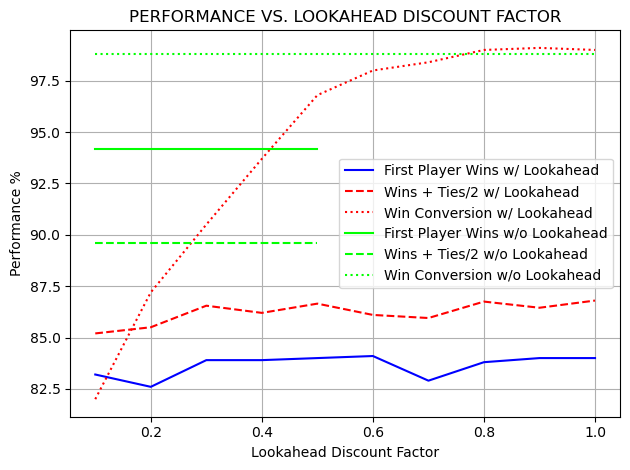

In [54]:
import matplotlib.pyplot as plt
import numpy as np

lookahead_discount = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

overall_wins = [83.6, 83.9, 85.1,84.7,84.9,84.8,84.3,85.3,85.0, 85.2]
ties = [3.2,3.2,2.9,3.0,3.5,2.6,3.3, 2.9,2.9,3.2]
wins_plus_half_ties = np.add(overall_wins,np.multiply(0.5,ties))
first_player_wins = [83.2, 82.6, 83.9, 83.9, 84.0, 84.1, 82.9, 83.8, 84.0, 84.0]
win_conversion = [82.0, 87.2, 90.5, 93.7, 96.8, 98.0, 98.4, 99.0, 99.1, 99.0]
block_conversion = [95.5, 95.3, 95.4, 95.7, 96.2, 96.0, 96.0, 95.7, 96.1, 96.1]

#plt.plot(lookahead_discount,overall_wins, color= "red", linestyle= "solid",label="Overall wins")
plt.plot(lookahead_discount,first_player_wins, color= "blue", linestyle="solid",label="First Player Wins w/ Lookahead")
plt.plot(lookahead_discount,wins_plus_half_ties, color= "red", linestyle="dashed",label="Wins + Ties/2 w/ Lookahead")
plt.plot(lookahead_discount,win_conversion, color= "red", linestyle="dotted",label="Win Conversion w/ Lookahead")
#plt.plot(lookahead_discount,block_conversion, color= "grey", linestyle="dashdot",label="Block Conversion")

plt.plot([0.1,0.5],[94.2,94.2], color= "lime", linestyle="solid",label="First Player Wins w/o Lookahead")
plt.plot([0.1,0.5],[89.6,89.6], color= "lime", linestyle="dashed",label="Wins + Ties/2 w/o Lookahead")
plt.plot([0.1,1.0],[98.8,98.8], color= "lime", linestyle="dotted",label="Win Conversion w/o Lookahead")
#plt.plot([0.1.0.5],[87.7,87.7], color= "yellow", linestyle="solid",label="Overall Wins w/o Lookahead")

plt.title("PERFORMANCE VS. LOOKAHEAD DISCOUNT FACTOR")
plt.xlabel("Lookahead Discount Factor")
plt.ylabel("Performance %")
#plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.savefig('PerformanceVsLookaheadDiscount.png')
plt.show